In [1]:
import pandas as pd
import numpy as np
import re
import random
from sklearn.utils import shuffle
import tensorflow as tf
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from afinn import Afinn
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Input
import tensorflow_hub as hub
from sklearn.svm import LinearSVC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from transformers import BertTokenizer, TFBertModel
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models, optimizers
from itertools import product
from imblearn.over_sampling import SMOTE
from transformers import BertTokenizer
from itertools import product
import csv
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Activation

from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

from tensorflow.keras import layers, models, optimizers
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder

from keras_tuner import GridSearch as kt

import numpy as np
from scipy.stats import sem, t, shapiro
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Import data
parlvote = pd.read_csv('ParlVote_concat.csv', header=None)
first_row = parlvote.iloc[0].tolist()
parlvote.columns = first_row
parlvote = parlvote.drop(index=0)

#########################BEGIN SAMPLE##################################
#parlvote =  parlvote.sample(n=300, random_state=42)
##########################END SAMPLE###################################

### Train for domain specific lexion ####
# Preprocess
# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the set of stopwords
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords and lemmatize
    return [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalpha()]

# Apply preprocessing to the 'speech' column and store the result in 'speech_processed'
parlvote['speech_processed'] = parlvote['speech'].apply(preprocess_text)

parlvote['speech_svm'] = parlvote['speech_processed'].apply(' '.join)

## Train Word2Vec model

# Function to preprocess text
def preprocess_word2vec(text):
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords
    return [token for token in tokens if token not in stop_words and token.isalpha()]

parlvote['speech_word2vec'] = parlvote['speech'].apply(preprocess_word2vec)

# Calculate corpus size in tokens
corpus_size = sum(len(speech) for speech in parlvote['speech_word2vec'])

# Vocabulary size
vocabulary = set(word for speech in parlvote['speech_word2vec'] for word in speech)
vocabulary_size = len(vocabulary)

# Put stats into a DataFrame
stats_df = pd.DataFrame({
    "Statistic": ["Corpus size", "Vocabulary size"],
    "Value": [corpus_size, vocabulary_size]
})

# Save the DataFrame to a CSV file
stats_df.to_csv("corpus_vocabulary_stats.csv", index=False)

model = Word2Vec(parlvote['speech_word2vec'], vector_size=300, window=6, min_count=10, workers=4)
model.train(parlvote['speech_word2vec'], total_examples=len(parlvote['speech_word2vec']), epochs=5)


# ######## REMOVE speeches with >512 tokens ##########
rem_token = []
sh_pv_before = parlvote.shape

## Instantiate the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")


# Tokenize the speeches and count tokens
parlvote['token_length'] = parlvote['speech'].apply(lambda x: len(tokenizer.tokenize(x)))

# Filter out rows with more than 512 tokens
max_tokens = 512
parlvote = parlvote[parlvote['token_length'] <= max_tokens]

# Now 'filtered_parlvote' is a DataFrame containing only rows with no more than 512 BERT tokens in the 'speech' column
# Shape after removing neutral
sh_pv_after = parlvote.shape
rem_token.append({"original" : sh_pv_before, ">512 removed" : sh_pv_after})
rem_token_df = pd.DataFrame(rem_token)

# Save the new DataFrame to a CSV file
rem_token_df.to_csv("removed_512.csv", index=False)


##### GENERATE SENTIMENT LABELS ########
### Domain Specific ####

def sentiment_score(words, model, positive_seeds, negative_seeds):
    score = 0
    for word in words:
        if word in model.wv:
            word_vector = model.wv[word]
            
            # Sum of cosine similarities with positive seed words
            for seed in positive_seeds:
                if seed in model.wv:
                    seed_vector = model.wv[seed]
                    score += np.dot(word_vector, seed_vector) / (np.linalg.norm(word_vector) * np.linalg.norm(seed_vector))
                    
            # Subtract sum of cosine similarities with negative seed words
            for seed in negative_seeds:
                if seed in model.wv:
                    seed_vector = model.wv[seed]
                    score -= np.dot(word_vector, seed_vector) / (np.linalg.norm(word_vector) * np.linalg.norm(seed_vector))
    
    return score


positive_seeds = ["good", "excellent", "correct", "best", "happy", "positive", "fortunate"]
negative_seeds = ["bad", "terrible", "wrong", "worst", "disappointed", "negative", "unfortunate"]

# Generate raw sentiment scores
raw_sentiment_scores = [sentiment_score(speech, model, positive_seeds, negative_seeds) for speech in parlvote['speech_word2vec']]

# Reshape the scores to fit the scaler input
raw_sentiment_scores = np.array(raw_sentiment_scores).reshape(-1, 1)

# Create a MinMaxScaler object with feature range of -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler to the data and transform the data
scaled_sentiment_scores = scaler.fit_transform(raw_sentiment_scores)

# Create 'domain_sentiment' column in the parlvote dataframe
parlvote['domain_sentiment'] = scaled_sentiment_scores.flatten()


###### BREAK #########
# if 1 == 1:
#     raise ValueError("Stopping execution at this cell")


### Standard Lexicons ###

# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()
afinn_analyzer = Afinn()
textblob_analyzer = TextBlob

# Define a function to generate the sentiment scores for each row
def generate_sentiment_scores(row):
    text = row['speech']
    
    # Generate VADER sentiment score
    vader_scores = vader_analyzer.polarity_scores(text)['compound']
    
    # Generate Afinn sentiment score
    afinn_score = afinn_analyzer.score(text)
    
    # Generate TextBlob sentiment score
    textblob_score = textblob_analyzer(text).sentiment.polarity
    
    return pd.Series([vader_scores, textblob_score, afinn_score])


# Apply the function to generate sentiment scores for each row and store the scores in new columns
parlvote[['vader', 'textblob', 'afinn']] = parlvote.apply(generate_sentiment_scores, axis=1)


# Define a function to convert VADER sentiment scores to labels
def vader_score_to_label(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Define a function to convert TextBlob sentiment scores to labels
def textblob_score_to_label(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

# Define a function to convert Afinn sentiment scores to labels
def afinn_score_to_label(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'


# Apply the label conversion functions to the sentiment score columns
parlvote['vader'] = parlvote['vader'].apply(vader_score_to_label)
parlvote['textblob'] = parlvote['textblob'].apply(textblob_score_to_label)
parlvote['afinn'] = parlvote['afinn'].apply(afinn_score_to_label)
parlvote['domain_sentiment'] = parlvote['domain_sentiment'].apply(textblob_score_to_label)

######### REMOVE 'NEUTRAL' LABELS #########
# Shape before removing neutral
removed = []
before = parlvote.shape

# remove instances where a row contains 'neutral'
pv = parlvote.loc[~((parlvote['vader'] == 'Neutral') | (parlvote['textblob'] == 'Neutral') | (parlvote['afinn'] == 'Neutral') | (parlvote['domain_sentiment'] == 'Neutral'))]
# Create a copy of the DataFrame to avoid modifying the original DataFrame
pv = pv.copy()

# Shape after removing neutral
after = pv.shape
removed.append({"original" : before, "neutral removed" : after})
removed_df = pd.DataFrame(removed)

# Save the new DataFrame to a CSV file
removed_df.to_csv("removed_neutral.csv", index=False)


######## CHANGE TO BINARY #########
def label_to_binary(label):
    if label == 'Positive':
        return 1
    else:
        return 0


def str_to_int(label):
    if label == '1':
        return 1
    else:
        return 0


# Convert sentiment labels to binary values for 'vader', 'textblob', 'afinn' and 'domain_sentiment' columns
pv['vader'] = pv['vader'].apply(label_to_binary)
pv['textblob'] = pv['textblob'].apply(label_to_binary)
pv['afinn'] = pv['afinn'].apply(label_to_binary)
pv['domain_sentiment'] = pv['domain_sentiment'].apply(label_to_binary)

# Convert the string of 'vote' to integer
pv['vote'] = pv['vote'].apply(str_to_int)


####### EMBEDDINGS ########
# Load a pre-trained BERT model
embedding_model = SentenceTransformer('bert-base-cased')
# Generate embeddings for the 'speech' column
pv['embeddings'] = parlvote['speech'].apply(lambda x: embedding_model.encode(x, convert_to_numpy=True))
print("Shape of the first embedding: ", pv['embeddings'].iloc[0].shape)
# Now 'parlvote' has a new column 'embeddings' containing the embeddings as numpy arrays


# Define the label columns
label_columns = ["vote", "vader", "textblob", "afinn", "domain_sentiment"]

# Initialize an empty dictionary to store the distributions
distributions = {}

# For each label column, compute the distribution and store it in the dictionary
for label in label_columns:
    distributions[label] = pv[label].value_counts(normalize=True) * 100

# Convert the distributions dictionary into a DataFrame
distributions_df = pd.DataFrame(distributions)

# Transpose the DataFrame so that each row corresponds to a label
distributions_df = distributions_df.transpose()

# Save the distributions DataFrame to a CSV file
distributions_df.to_csv("distributions.csv")


###### ONE-HOT ENCODE PV (train-val) AND PV_TEST #######
# Define a function to one-hot encode a column
def one_hot_encode(df, column):
    df[column + '_positive'] = (df[column] == 1).astype(int)
    df[column + '_negative'] = (df[column] == 0).astype(int)
    return df


# Apply the function to one-hot encode the columns in the 'pv' dataframe
pv = one_hot_encode(pv, 'vote')
pv = one_hot_encode(pv, 'vader')
pv = one_hot_encode(pv, 'textblob')
pv = one_hot_encode(pv, 'afinn')
pv = one_hot_encode(pv, 'domain_sentiment')

def print_majority_baselines(df, one_hot_encoded_columns):
    for columns in one_hot_encoded_columns:
        majority_class = df[columns].sum(axis=0).idxmax()
        majority_baseline = df[majority_class].mean()
        
        print(f"Majority baseline for {', '.join(columns)}:")
        print(f"  Majority class: {majority_class}")
        print(f"  Baseline accuracy: {majority_baseline:.2%}\n")

# usage
one_hot_encoded_columns = [
    ['vote_positive', 'vote_negative'],
    ['vader_positive', 'vader_negative'],
    ['textblob_positive', 'textblob_negative'],
    ['afinn_positive', 'afinn_negative'], 
    ['domain_sentiment_positive', 'domain_sentiment_negative']
]

backup = pv.copy()



##### LABEL DISTRIBUTIONS #######
# Split the data into train+val (90%) and test (10%)
pv, pv_test = train_test_split(pv, test_size=0.10, random_state=1)

##### PRINT MAJORITY BASELINES FOR PV ######
print_majority_baselines(pv, one_hot_encoded_columns)

#### PRINT MAJORITY BASELINES FOR PV_TEST #####
def majority_baseline(df, columns):
        majority_class = df[columns].sum(axis=0).idxmax()
        majority_baseline = df[majority_class].mean()
        return majority_baseline

vote_majority = majority_baseline(pv_test, one_hot_encoded_columns[0])
vader_majority = majority_baseline(pv_test, one_hot_encoded_columns[1])
textblob_majority = majority_baseline(pv_test, one_hot_encoded_columns[2])
afinn_majority = majority_baseline(pv_test, one_hot_encoded_columns[3])
domain_majority = majority_baseline(pv_test, one_hot_encoded_columns[4])

# Convert one-hot encoded columns to a NumPy array
vote_labels = pv[['vote_positive', 'vote_negative']].values
vader_labels = pv[['vader_positive', 'vader_negative']].values
textblob_labels = pv[['textblob_positive', 'textblob_negative']].values
afinn_labels = pv[['afinn_positive', 'afinn_negative']].values
domain_labels = pv[['domain_sentiment_positive', 'domain_sentiment_negative']].values

# Convert one-hot encoded columns to a NumPy array
vote_labels_test = pv_test[['vote_positive', 'vote_negative']].values
vader_labels_test = pv_test[['vader_positive', 'vader_negative']].values
textblob_labels_test = pv_test[['textblob_positive', 'textblob_negative']].values
afinn_labels_test = pv_test[['afinn_positive', 'afinn_negative']].values
domain_labels_test = pv_test[['domain_sentiment_positive', 'domain_sentiment_negative']].values

# Convert one-hot encoded columns to a NumPy array for SVM
pv_svm = pd.concat([pv, pv_test], axis=0)

vote_labels_svm = pv_svm[['vote_positive', 'vote_negative']].values
vader_labels_svm = pv_svm[['vader_positive', 'vader_negative']].values
textblob_labels_svm = pv_svm[['textblob_positive', 'textblob_negative']].values
afinn_labels_svm = pv_svm[['afinn_positive', 'afinn_negative']].values
domain_labels_svm = pv_svm[['domain_sentiment_positive', 'domain_sentiment_negative']].values

C:\Users\beren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:44: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\beren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\beren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\beren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
No sentence-transformers model found with name C:\Users\beren/.cache\torch\sentence_transformers\bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\beren/.cache\torch\sentence_transformers\bert-base-cased were not used when init

Shape of the first embedding:  (768,)
Majority baseline for vote_positive, vote_negative:
  Majority class: vote_positive
  Baseline accuracy: 54.06%

Majority baseline for vader_positive, vader_negative:
  Majority class: vader_positive
  Baseline accuracy: 77.28%

Majority baseline for textblob_positive, textblob_negative:
  Majority class: textblob_positive
  Baseline accuracy: 84.09%

Majority baseline for afinn_positive, afinn_negative:
  Majority class: afinn_positive
  Baseline accuracy: 71.94%

Majority baseline for domain_sentiment_positive, domain_sentiment_negative:
  Majority class: domain_sentiment_negative
  Baseline accuracy: 75.80%



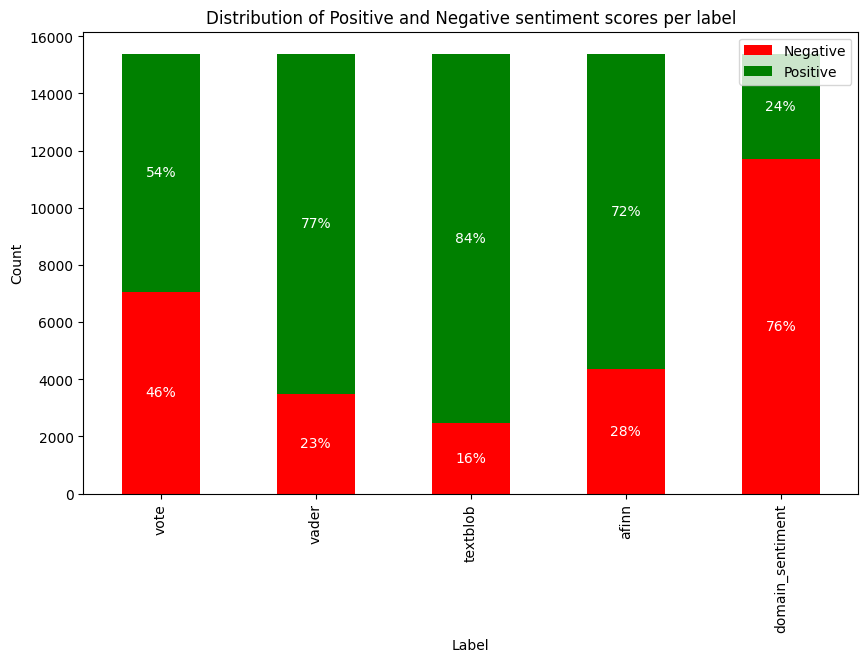

In [659]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the distributions dataframe
distributions_df = pd.read_csv('distributions.csv', index_col=0)

# Scale the percentages to the actual count
total_count = 15396
distributions_df = distributions_df * total_count / 100

# Transpose the DataFrame
distributions_df.columns = ['Negative', 'Positive']

# Define colors for the sentiment categories
colors = ["red", "green"]

# Plot the bar chart
ax = distributions_df.plot(kind="bar", stacked=True, color=colors, figsize=(10, 6))

plt.title('Distribution of Positive and Negative sentiment scores per label')
plt.xlabel('Label')
plt.ylabel('Count')

# Add percentage annotations
for i, (label, row) in enumerate(distributions_df.iterrows()):
    for j, (sentiment, count) in enumerate(row.iteritems()):
        # Compute the percentage
        percentage = count / total_count * 100
        # Compute the y position: half of the height of the bar segment
        if j == 0:  # 'Negative'
            y_pos = count / 2
        else:  # 'Positive'
            y_pos = row['Negative'] + count / 2
        ax.text(i, y_pos, f'{percentage:.0f}%', ha='center', va='center', color='white')

plt.show()

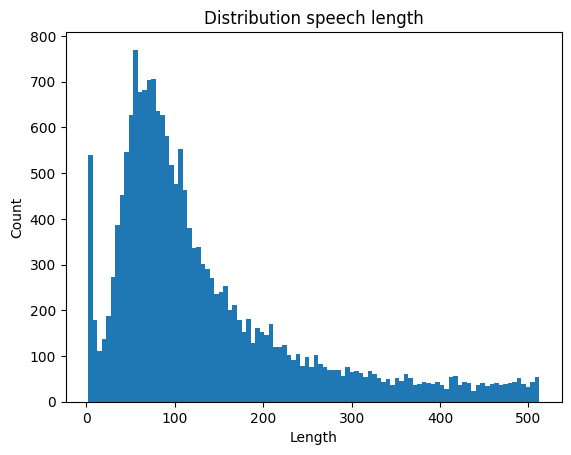

In [660]:
# visualise the distribution of the speech length
plt.hist(parlvote['token_length'], bins=100)
plt.title("Distribution speech length")
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

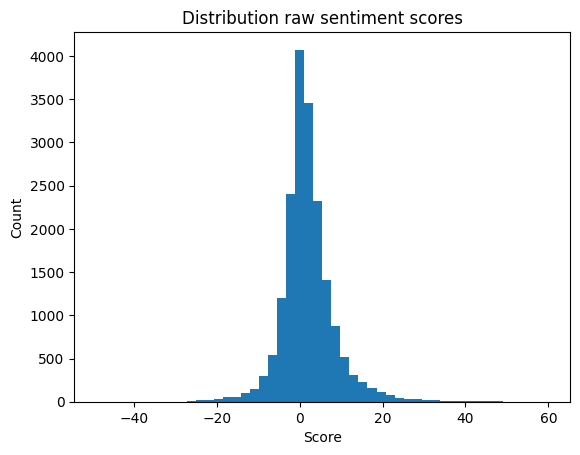

In [662]:
import matplotlib.pyplot as plt

# visualise the distribution of the raw sentiment scores for domain-specific lexicon
plt.hist(raw_sentiment_scores, bins=50)
plt.title("Distribution raw sentiment scores")
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

## HYPERPARAMETER OPTIMIZATION 

In [665]:
####### SETUP MODEL ########
data = pv['embeddings']

In [666]:
type(data)

pandas.core.series.Series

In [667]:
# Convert data series to NumPy array
data = np.stack(data, axis=0) 


In [668]:
######## HYPERMODEL FOR VOTE (different dropout) #######
class SentimentAnalysisHyperModel_1(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = models.Sequential()
        model.add(layers.Input(shape=self.input_shape))
        model.add(layers.Reshape((1, self.input_shape[0])))
        model.add(layers.SpatialDropout1D(0.3)),
        model.add(layers.Bidirectional(layers.LSTM(units=hp.Choice('lstm_units', values=[64, 128, 512]),
                                               dropout=0.3, recurrent_dropout=0.3)))
        model.add(layers.Dense(units=hp.Choice('dense_units', values=[64, 128, 512]), activation='relu'))
        model.add(layers.Dropout(0.4))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=optimizers.Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall')
              ])

        return model

In [669]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [671]:
import json

In [672]:
######## HPO 'Vote' ########

input_shape = (data.shape[1],)
num_classes = vote_labels.shape[1]

hypermodel_1 = SentimentAnalysisHyperModel_1(input_shape, num_classes)


tuner_vote = kt(
    hypermodel_1,
    objective='val_accuracy',
    max_trials=9,
    executions_per_trial=3,
    directory='output',
    project_name='sentiment_analysis_vote')


tuner_vote.search(x=data,
             y=vote_labels,
             epochs=10,
             validation_split=0.1)

# Save best HPS
best_hps_vote = tuner_vote.get_best_hyperparameters(num_trials=1)[0]
best_hps_str_vote = json.dumps(best_hps_vote.values)

# Build  with best HPS
model_vote = tuner_vote.hypermodel.build(best_hps_vote)

# and train model
history_vote = model_vote.fit(data, vote_labels, epochs=50, validation_split=0.1, callbacks=[early_stopping])

# Save model with best HPS
model_vote.save('best_model_vote.h5')

# Get the performance metrics from the last epoch
performance_vote = {
    'accuracy': history_vote.history['val_accuracy'][-1],
    'precision': history_vote.history['val_precision'][-1],
    'recall': history_vote.history['val_recall'][-1],
    'best_param' : best_hps_str_vote
}

# Save as dataframe
performance_df_vote = pd.DataFrame([performance_vote])
performance_df_vote.to_csv('performance_vote.csv', index=False)

INFO:tensorflow:Reloading Tuner from output\sentiment_analysis_vote\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
187/187 [==============================] - 8s 13ms/step - loss: 0.6932 - accuracy: 0.5294 - precision: 0.5294 - recall: 0.5294 - val_loss: 0.6908 - val_accuracy: 0.5415 - val_precision: 0.5415 - val_recall: 0.5415
Epoch 2/50
187/187 [==============================] - 2s 8ms/step - loss: 0.6924 - accuracy: 0.5258 - precision: 0.5258 - recall: 0.5258 - val_loss: 0.6914 - val_accuracy: 0.5189 - val_precision: 0.5189 - val_recall: 0.5189
Epoch 3/50
187/187 [==============================] - 2s 10ms/step - loss: 0.6909 - accuracy: 0.5382 - precision: 0.5382 - recall: 0.5382 - val_loss: 0.6906 - val_accuracy: 0.5158 - val_precision: 0.5158 - val_recall: 0.5158
Epoch 4/50
187/187 [==============================] - 2s 9ms/step - loss: 0.6886 - accuracy: 0.5374 - precision: 0.5374 - recall: 0.5374 - val_loss: 0.6904 - val_accuracy: 0.5173 - val_precision: 0.5173 - val

In [673]:
from tensorflow.keras.models import load_model

# Load the model
model_afinn = load_model('best_model_vote.h5')

# Print the summary (architecture)
model_afinn.summary()

# Print layer configurations
for layer in model_afinn.layers:
    print(layer.get_config())
    
# Print weights
for layer in model_afinn.layers:
    print(layer.get_weights())

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_46 (Reshape)        (None, 1, 768)            0         
                                                                 
 spatial_dropout1d_46 (Spati  (None, 1, 768)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_46 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_184 (Dense)           (None, 64)                8256      
                                                                 
 dropout_92 (Dropout)        (None, 64)                0         
                                                                 
 dense_185 (Dense)           (None, 2)               

In [675]:
###### HYPERMODEL FOR AUTOMATIC SENTIMENT LABELS (different dropout) #########
class SentimentAnalysisHyperModel_2(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = models.Sequential()
        model.add(layers.Input(shape=self.input_shape))
        model.add(layers.Reshape((1, self.input_shape[0])))
        model.add(layers.SpatialDropout1D(0.2)),
        model.add(layers.Bidirectional(layers.LSTM(units=hp.Choice('lstm_units', values=[64, 128, 512]),
                                               dropout=0.2, recurrent_dropout=0.2)))
        model.add(layers.Dense(units=hp.Choice('dense_units', values=[64, 128, 512]), activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall')
              ])

        return model

In [676]:
######## HPO 'VADER' ########
input_shape = (data.shape[1],)
num_classes = vader_labels.shape[1]

hypermodel_2 = SentimentAnalysisHyperModel_2(input_shape, num_classes)

tuner_vader = kt(
    hypermodel_2,
    objective='val_accuracy',
    max_trials=9,
    executions_per_trial=3,
    directory='output',
    project_name='sentiment_analysis_vader')

tuner_vader.search(x=data,
             y=vader_labels,
             epochs=10,
             validation_split=0.1)

# Save best HPS
best_hps_vader = tuner_vader.get_best_hyperparameters(num_trials=1)[0]
best_hps_vader_str = json.dumps(best_hps_vader.values)

# Build and train model with best HPS
model_vader = tuner_vader.hypermodel.build(best_hps_vader)
history_vader = model_vader.fit(data, vader_labels, epochs=50, validation_split=0.1, callbacks=[early_stopping])

# Save model with best HPS
model_vader.save('best_model_vader.h5')

# Get the performance metrics from the last epoch
performance_vader = {
    'accuracy': history_vader.history['val_accuracy'][-1],
    'precision': history_vader.history['val_precision'][-1],
    'recall': history_vader.history['val_recall'][-1],
    'best_param' : best_hps_vader_str
}

# Save as dataframe
performance_df_vader = pd.DataFrame([performance_vader])
performance_df_vader.to_csv('performance_vader.csv', index=False)


INFO:tensorflow:Reloading Tuner from output\sentiment_analysis_vader\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
187/187 [==============================] - 7s 14ms/step - loss: 0.4911 - accuracy: 0.7835 - precision: 0.7835 - recall: 0.7835 - val_loss: 0.4483 - val_accuracy: 0.7888 - val_precision: 0.7888 - val_recall: 0.7888
Epoch 2/50
187/187 [==============================] - 2s 11ms/step - loss: 0.4346 - accuracy: 0.7981 - precision: 0.7981 - recall: 0.7981 - val_loss: 0.4583 - val_accuracy: 0.8069 - val_precision: 0.8069 - val_recall: 0.8069
Epoch 3/50
187/187 [==============================] - 2s 11ms/step - loss: 0.4180 - accuracy: 0.8061 - precision: 0.8061 - recall: 0.8061 - val_loss: 0.4298 - val_accuracy: 0.8024 - val_precision: 0.8024 - val_recall: 0.8024
Epoch 4/50
187/187 [==============================] - 2s 11ms/step - loss: 0.4107 - accuracy: 0.8108 - precision: 0.8108 - recall: 0.8108 - val_loss: 0.4277 - val_accuracy: 0.8160 - val_precision: 0.8160 - 

In [677]:
from tensorflow.keras.models import load_model

# Load the model
model_afinn = load_model('best_model_vader.h5')

# Print the summary (architecture)
model_afinn.summary()

# Print layer configurations
for layer in model_afinn.layers:
    print(layer.get_config())
    
# Print weights
for layer in model_afinn.layers:
    print(layer.get_weights())

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_47 (Reshape)        (None, 1, 768)            0         
                                                                 
 spatial_dropout1d_47 (Spati  (None, 1, 768)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_47 (Bidirecti  (None, 256)              918528    
 onal)                                                           
                                                                 
 dense_186 (Dense)           (None, 64)                16448     
                                                                 
 dropout_93 (Dropout)        (None, 64)                0         
                                                                 
 dense_187 (Dense)           (None, 2)               

In [678]:
# Load version 2 with different dropout rates for VADER

# Load the previously saved model
model = load_model('best_model_vader.h5')

# Modify the dropout rates
model.layers[2].rate = 0.3  # SpatialDropout1D rate
model.layers[3].dropout = 0.3  # Bidirectional LSTM dropout rate
model.layers[5].rate = 0.3  # Dense dropout rate

# Save the modified model as a new version
model.save('best_model_vader_v2.h5')

In [679]:
######## HPO 'TextBlob' ########
input_shape = (data.shape[1],)
num_classes = textblob_labels.shape[1]

hypermodel_2 = SentimentAnalysisHyperModel_2(input_shape, num_classes)

tuner_textblob = kt(
    hypermodel_2,
    objective='val_accuracy',
    max_trials=9,
    executions_per_trial=3,
    directory='output',
    project_name='sentiment_analysis_textblob')

tuner_textblob.search(x=data,
             y=textblob_labels,
             epochs=10,
             validation_split=0.1)

# Save best HPS
best_hps_textblob = tuner_textblob.get_best_hyperparameters(num_trials=1)[0]
best_hps_textblob_str = json.dumps(best_hps_textblob.values)

# Build and train model with best HPS
model_textblob = tuner_textblob.hypermodel.build(best_hps_textblob)
history_textblob = model_textblob.fit(data, textblob_labels, epochs=50, validation_split=0.1, callbacks=[early_stopping])

# Save model with best HPS
model_textblob.save('best_model_textblob.h5')

# Get the performance metrics from the last epoch
performance_textblob = {
    'accuracy': history_textblob.history['val_accuracy'][-1],
    'precision': history_textblob.history['val_precision'][-1],
    'recall': history_textblob.history['val_recall'][-1],
    'best_param' : best_hps_textblob_str
}

# Save as dataframe
performance_df_textblob = pd.DataFrame([performance_textblob])
performance_df_textblob.to_csv('performance_textblob.csv', index=False)

INFO:tensorflow:Reloading Tuner from output\sentiment_analysis_textblob\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
187/187 [==============================] - 7s 14ms/step - loss: 0.4421 - accuracy: 0.8391 - precision: 0.8391 - recall: 0.8391 - val_loss: 0.3975 - val_accuracy: 0.8552 - val_precision: 0.8552 - val_recall: 0.8552
Epoch 2/50
187/187 [==============================] - 2s 11ms/step - loss: 0.4186 - accuracy: 0.8405 - precision: 0.8405 - recall: 0.8405 - val_loss: 0.3999 - val_accuracy: 0.8567 - val_precision: 0.8567 - val_recall: 0.8567
Epoch 3/50
187/187 [==============================] - 2s 11ms/step - loss: 0.4110 - accuracy: 0.8415 - precision: 0.8415 - recall: 0.8415 - val_loss: 0.4073 - val_accuracy: 0.8567 - val_precision: 0.8567 - val_recall: 0.8567
Epoch 4/50
187/187 [==============================] - 2s 11ms/step - loss: 0.4002 - accuracy: 0.8420 - precision: 0.8420 - recall: 0.8420 - val_loss: 0.3942 - val_accuracy: 0.8567 - val_precision: 0.8567

In [680]:
from tensorflow.keras.models import load_model

# Load the model
model_afinn = load_model('best_model_textblob.h5')

# Print the summary (architecture)
model_afinn.summary()

# Print layer configurations
for layer in model_afinn.layers:
    print(layer.get_config())
    
# Print weights
for layer in model_afinn.layers:
    print(layer.get_weights())

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_48 (Reshape)        (None, 1, 768)            0         
                                                                 
 spatial_dropout1d_48 (Spati  (None, 1, 768)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_48 (Bidirecti  (None, 256)              918528    
 onal)                                                           
                                                                 
 dense_188 (Dense)           (None, 64)                16448     
                                                                 
 dropout_94 (Dropout)        (None, 64)                0         
                                                                 
 dense_189 (Dense)           (None, 2)               

In [681]:
# Load version 2 with different dropout rates for TextBlob

# Load the previously saved model
model = load_model('best_model_textblob.h5')

# Modify the dropout rates
model.layers[2].rate = 0.3  # SpatialDropout1D rate
model.layers[3].dropout = 0.3  # Bidirectional LSTM dropout rate
model.layers[5].rate = 0.3  # Dense dropout rate

# Save the modified model as a new version
model.save('best_model_textblob_v2.h5')

In [682]:
######## HPO 'AFINN' ########
input_shape = (data.shape[1],)
num_classes = afinn_labels.shape[1]

hypermodel_2 = SentimentAnalysisHyperModel_2(input_shape, num_classes)

tuner_afinn = kt(
    hypermodel_2,
    objective='val_accuracy',
    max_trials=9,
    executions_per_trial=3,
    directory='output',
    project_name='sentiment_analysis_afinn')

tuner_afinn.search(x=data,
             y=afinn_labels,
             epochs=10,
             validation_split=0.1)

# Save best HPS
best_hps_afinn = tuner_afinn.get_best_hyperparameters(num_trials=1)[0]
best_hps_str_afinn = json.dumps(best_hps_afinn.values)

# Build and train model with best HPS
model_afinn = tuner_afinn.hypermodel.build(best_hps_afinn)
history_afinn = model_afinn.fit(data, afinn_labels, epochs=50, validation_split=0.1, callbacks=[early_stopping])

# Save model with best HPS
model_afinn.save('best_model_afinn.h5')

# Get the performance metrics from the last epoch
performance_afinn = {
    'accuracy': history_afinn.history['val_accuracy'][-1],
    'precision': history_afinn.history['val_precision'][-1],
    'recall': history_afinn.history['val_recall'][-1],
    'best_param' : best_hps_str_afinn
}

# Save as dataframe
performance_df_afinn = pd.DataFrame([performance_afinn])
performance_df_afinn.to_csv('performance_afinn.csv', index=False)

INFO:tensorflow:Reloading Tuner from output\sentiment_analysis_afinn\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
187/187 [==============================] - 9s 16ms/step - loss: 0.5456 - accuracy: 0.7311 - precision: 0.7311 - recall: 0.7311 - val_loss: 0.4737 - val_accuracy: 0.7768 - val_precision: 0.7768 - val_recall: 0.7768
Epoch 2/50
187/187 [==============================] - 2s 10ms/step - loss: 0.4713 - accuracy: 0.7789 - precision: 0.7789 - recall: 0.7789 - val_loss: 0.4588 - val_accuracy: 0.7707 - val_precision: 0.7707 - val_recall: 0.7707
Epoch 3/50
187/187 [==============================] - 2s 10ms/step - loss: 0.4491 - accuracy: 0.7863 - precision: 0.7863 - recall: 0.7863 - val_loss: 0.4501 - val_accuracy: 0.7858 - val_precision: 0.7858 - val_recall: 0.7858
Epoch 4/50
187/187 [==============================] - 2s 10ms/step - loss: 0.4558 - accuracy: 0.7840 - precision: 0.7840 - recall: 0.7840 - val_loss: 0.4988 - val_accuracy: 0.7451 - val_precision: 0.7451 - 

In [683]:
from tensorflow.keras.models import load_model

# Load the model
model_afinn = load_model('best_model_afinn.h5')

# Print the summary (architecture)
model_afinn.summary()

# Print layer configurations
for layer in model_afinn.layers:
    print(layer.get_config())
    
# Print weights
for layer in model_afinn.layers:
    print(layer.get_weights())

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_49 (Reshape)        (None, 1, 768)            0         
                                                                 
 spatial_dropout1d_49 (Spati  (None, 1, 768)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_49 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_190 (Dense)           (None, 64)                8256      
                                                                 
 dropout_95 (Dropout)        (None, 64)                0         
                                                                 
 dense_191 (Dense)           (None, 2)               

In [684]:
# Load version 2 with different dropout rates for AFINN

# Load the previously saved model
model = load_model('best_model_afinn.h5')

# Modify the dropout rates
model.layers[2].rate = 0.3  # SpatialDropout1D rate
model.layers[3].dropout = 0.3  # Bidirectional LSTM dropout rate
model.layers[5].rate = 0.3  # Dense dropout rate

# Save the modified model as a new version
model.save('best_model_afinn_v2.h5')

In [685]:
######## HPO 'DOMAIN' ########
input_shape = (data.shape[1],)
num_classes = domain_labels.shape[1]

hypermodel_2 = SentimentAnalysisHyperModel_2(input_shape, num_classes)

tuner_domain = kt(
    hypermodel_2,
    objective='val_accuracy',
    max_trials=9,
    executions_per_trial=3,
    directory='output',
    project_name='sentiment_analysis_domain')

tuner_domain.search(x=data,
             y=domain_labels,
             epochs=10,
             validation_split=0.1)

# Save best HPS
best_hps_domain = tuner_domain.get_best_hyperparameters(num_trials=1)[0]
best_hps_domain_str = json.dumps(best_hps_domain.values)

# Build and train model with best HPS
model_domain = tuner_domain.hypermodel.build(best_hps_domain)
history_domain = model_domain.fit(data, domain_labels, epochs=50, validation_split=0.1, callbacks=[early_stopping])

# Save model with best HPS
model_domain.save('best_model_domain.h5')

# Get the performance metrics from the last epoch
performance_domain = {
    'accuracy': history_domain.history['val_accuracy'][-1],
    'precision': history_domain.history['val_precision'][-1],
    'recall': history_domain.history['val_recall'][-1],
    'best_param' : best_hps_domain_str
}

# Save as dataframe
performance_df_domain = pd.DataFrame([performance_domain])
performance_df_domain.to_csv('performance_domain.csv', index=False)

INFO:tensorflow:Reloading Tuner from output\sentiment_analysis_domain\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
187/187 [==============================] - 15s 53ms/step - loss: 0.3951 - accuracy: 0.8121 - precision: 0.8121 - recall: 0.8121 - val_loss: 0.3251 - val_accuracy: 0.8612 - val_precision: 0.8612 - val_recall: 0.8612
Epoch 2/50
187/187 [==============================] - 9s 48ms/step - loss: 0.3217 - accuracy: 0.8517 - precision: 0.8517 - recall: 0.8517 - val_loss: 0.2968 - val_accuracy: 0.8643 - val_precision: 0.8643 - val_recall: 0.8643
Epoch 3/50
187/187 [==============================] - 9s 47ms/step - loss: 0.3171 - accuracy: 0.8554 - precision: 0.8554 - recall: 0.8554 - val_loss: 0.2845 - val_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 4/50
187/187 [==============================] - 9s 47ms/step - loss: 0.3090 - accuracy: 0.8611 - precision: 0.8611 - recall: 0.8611 - val_loss: 0.2835 - val_accuracy: 0.8688 - val_precision: 0.8688 

In [686]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('best_model_domain.h5')

# Print the summary (architecture)
model.summary()

# Print layer configurations
for layer in model.layers:
    print(layer.get_config())
    
# Print weights
for layer in model.layers:
    print(layer.get_weights())

Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_50 (Reshape)        (None, 1, 768)            0         
                                                                 
 spatial_dropout1d_50 (Spati  (None, 1, 768)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_50 (Bidirecti  (None, 1024)             5246976   
 onal)                                                           
                                                                 
 dense_192 (Dense)           (None, 512)               524800    
                                                                 
 dropout_96 (Dropout)        (None, 512)               0         
                                                                 
 dense_193 (Dense)           (None, 2)               

In [687]:
# Load version 2 with different dropout rates for Domain

# Load the previously saved model
model = load_model('best_model_domain.h5')

# Modify the dropout rates
model.layers[2].rate = 0.3  # SpatialDropout1D rate
model.layers[3].dropout = 0.3  # Bidirectional LSTM dropout rate
model.layers[5].rate = 0.3  # Dense dropout rate

# Save the modified model as a new version
model.save('best_model_domain_v2.h5')

In [688]:
# Create combined performance dataframe
dataframes = [performance_df_vote, performance_df_vader, performance_df_textblob, performance_df_afinn, performance_df_domain ]
names = ['vote', 'vader', 'textblob', 'afinn', 'domain']

# Concatenate the dataframes
combined_df = pd.concat(dataframes, keys=names)

# Rename the index
combined_df.index.names = ['model', 'original_index']

In [689]:
combined_df
combined_df.to_csv('combined_performance.csv')

### Plotting train-val loss

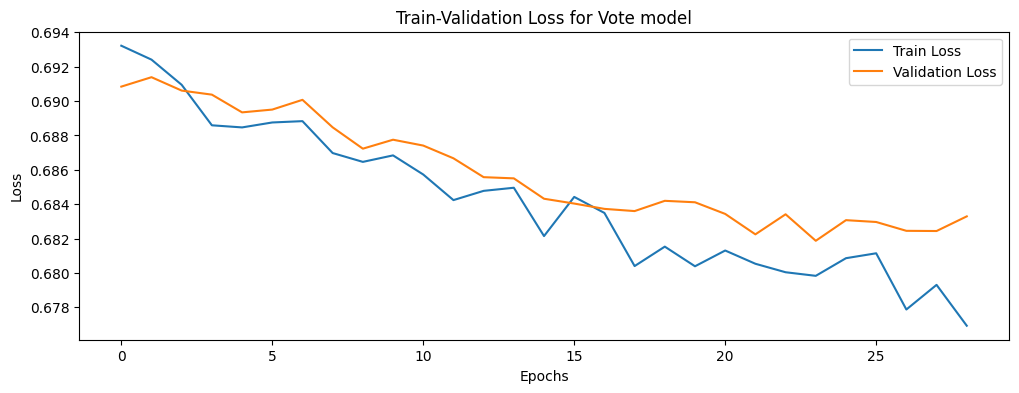

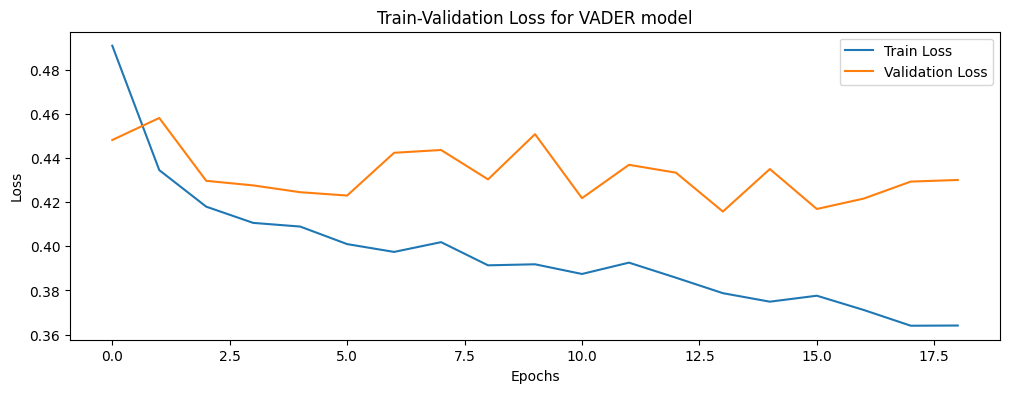

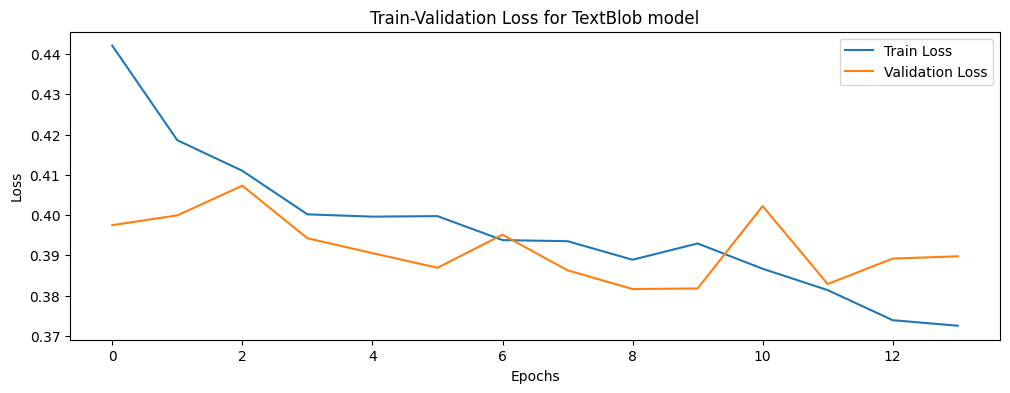

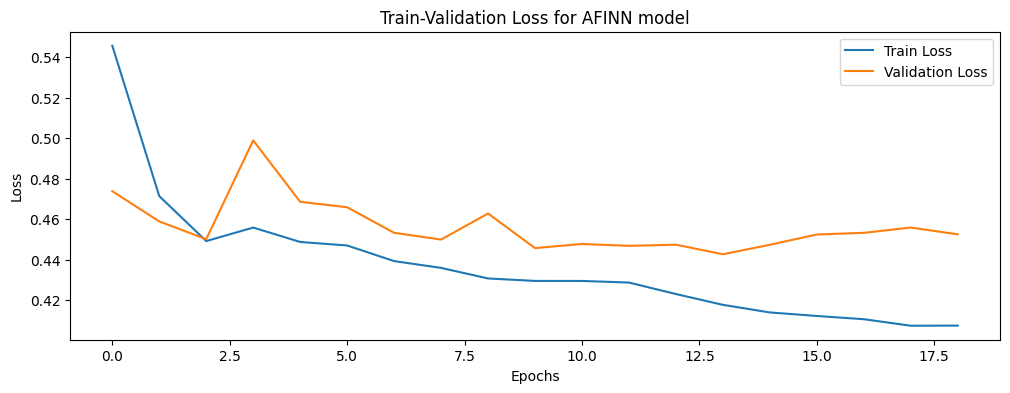

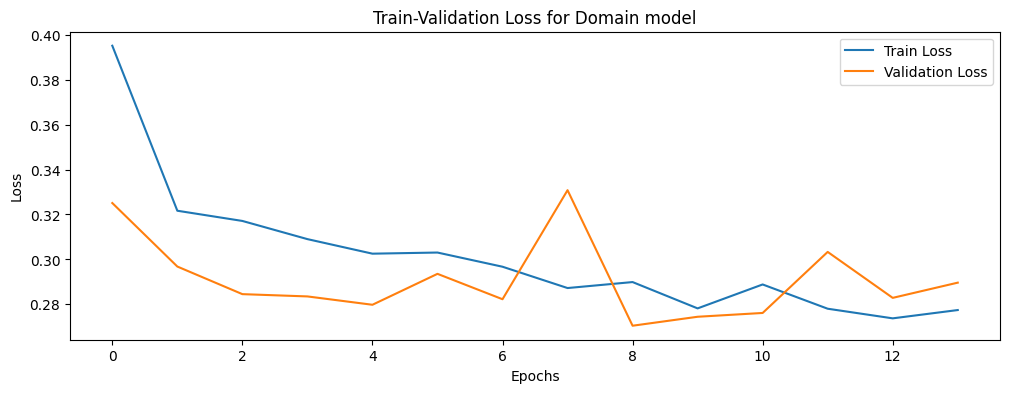

In [690]:
# Plotting train-validation loss graphs
plt.figure(figsize=(12, 4))
plt.plot(history_vote.history['loss'], label='Train Loss')
plt.plot(history_vote.history['val_loss'], label='Validation Loss')
plt.title('Train-Validation Loss for Vote model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history_vader.history['loss'], label='Train Loss')
plt.plot(history_vader.history['val_loss'], label='Validation Loss')
plt.title('Train-Validation Loss for VADER model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history_textblob.history['loss'], label='Train Loss')
plt.plot(history_textblob.history['val_loss'], label='Validation Loss')
plt.title('Train-Validation Loss for TextBlob model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history_afinn.history['loss'], label='Train Loss')
plt.plot(history_afinn.history['val_loss'], label='Validation Loss')
plt.title('Train-Validation Loss for AFINN model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history_domain.history['loss'], label='Train Loss')
plt.plot(history_domain.history['val_loss'], label='Validation Loss')
plt.title('Train-Validation Loss for Domain model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Making predictions

In [691]:
X_test = pv_test['embeddings']

In [692]:
# Convert data series to NumPy array
X_test = np.stack(X_test, axis=0) 

In [693]:
####### SETUP MODEL ########
data = pv['embeddings']

# Convert data series to NumPy array
data = np.stack(data, axis=0)  

In [694]:
# DEFINE stats 
stats = []

# Define the filename for the CSV file
filename = 'hpo_experiment_results.csv'

# Define the header for the CSV file
header = ['Experiment', 'Model', 'Train label', 'Test label', 'Accuracy', 'Precision', 'Recall', 'F1', 'Majority baseline']

In [695]:
#### INSTANTIATE FUNCTION SVM ####

def svm_pipeline(data, train_labels, test_labels, name, test_size=0.1):
    
    train_data, test_data, train_labels, _ = train_test_split(data, train_labels, test_size=test_size, stratify=vote_labels_svm, random_state=42)
    test_labels = test_labels[len(train_labels):]
    splits = [(range(len(train_data)), range(len(test_data)))]
    
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    
    train_labels = np.argmax(train_labels, axis=1)
    test_labels = np.argmax(test_labels, axis=1)
    le = LabelEncoder()
    train_labels = le.fit_transform(train_labels)
    test_labels = le.transform(test_labels)

    # Define the pipeline
    pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.9, min_df=5)),
    ('clf', LinearSVC(C=1.0, loss='squared_hinge', class_weight='balanced'))
    ])

    # Train the SVM classifier
    pipeline.fit(train_data, train_labels)

    y_pred = pipeline.predict(test_data)

    #EVALUATION METRICS
    accuracy = accuracy_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred)
    recall = recall_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred)
    
    # # Print the classification report
    # print(classification_report(test_labels, y_pred))

    # print(f"Accuracy: {accuracy:.2%}")
    # print(f"Precision: {precision:.2%}")
    # print(f"Recall: {recall:.2%}")
    # print(f"F1-score: {f1:.2%}")

    return accuracy, precision, recall, f1

### Experiment 1: Vote - Vote

In [696]:
import seaborn as sns

24/24 [==============================] - 1s 3ms/step


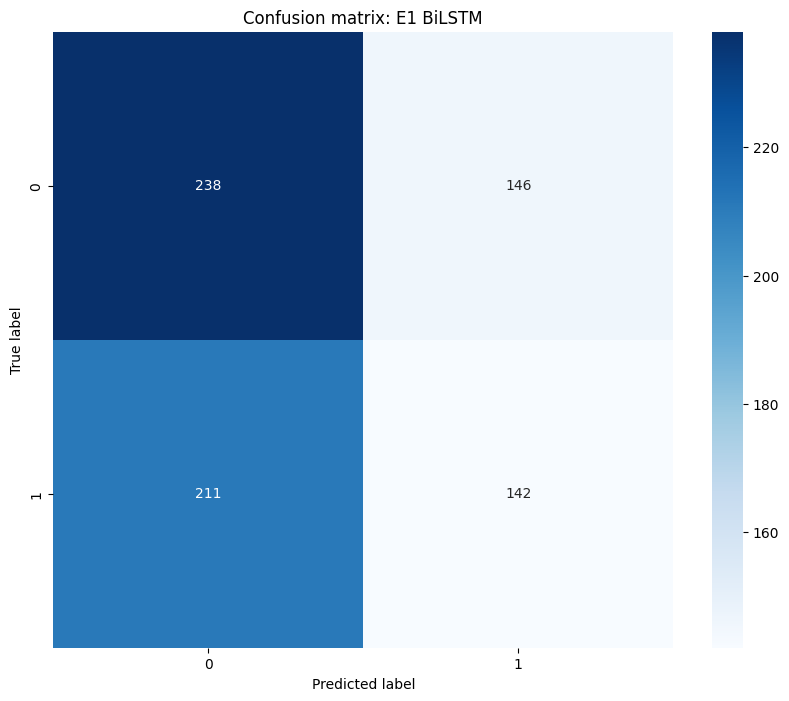

              precision    recall  f1-score   support

           0       0.53      0.62      0.57       384
           1       0.49      0.40      0.44       353

    accuracy                           0.52       737
   macro avg       0.51      0.51      0.51       737
weighted avg       0.51      0.52      0.51       737



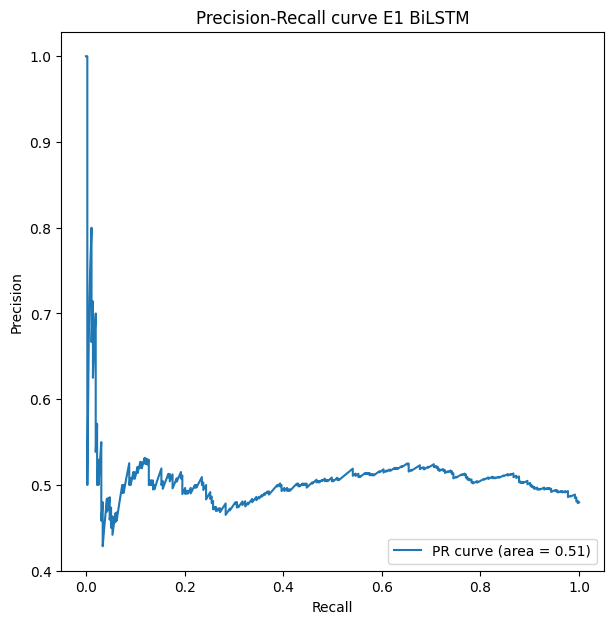

In [697]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_vote.h5')

# Test labels, X_train = data is already defined earlier
y_test = vote_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E1 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E1 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 1 - BiLSTM to the results list
stats.append(('1', 'BiLSTM', 'Vote', 'Vote', accuracy, precision, recall, f1, vote_majority))

In [698]:
####### train MLP #######
mlp_vote = Sequential([
    Dense(100, input_shape=(data.shape[1],)),  # Hidden layer of 100 nodes
    BatchNormalization(),  # Batch normalization
    Activation('relu'),  # ReLU activation function
    Dropout(0.5),  # Dropout regularization rate of 0.5
    Dense(vote_labels.shape[1], activation='sigmoid')  # Sigmoid activation in the output layer
])

mlp_vote.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_vote.fit(data, vote_labels, batch_size=32, epochs=10, verbose=1)


Epoch 1/10
208/208 [==============================] - 1s 3ms/step - loss: 0.8148 - accuracy: 0.5217
Epoch 2/10
208/208 [==============================] - 1s 3ms/step - loss: 0.7005 - accuracy: 0.5598
Epoch 3/10
208/208 [==============================] - 1s 4ms/step - loss: 0.6694 - accuracy: 0.5869
Epoch 4/10
208/208 [==============================] - 1s 4ms/step - loss: 0.6562 - accuracy: 0.6024
Epoch 5/10
208/208 [==============================] - 1s 3ms/step - loss: 0.6484 - accuracy: 0.6177
Epoch 6/10
208/208 [==============================] - 1s 3ms/step - loss: 0.6372 - accuracy: 0.6353
Epoch 7/10
208/208 [==============================] - 1s 3ms/step - loss: 0.6275 - accuracy: 0.6466
Epoch 8/10
208/208 [==============================] - 1s 3ms/step - loss: 0.6232 - accuracy: 0.6509
Epoch 9/10
208/208 [==============================] - 1s 3ms/step - loss: 0.6024 - accuracy: 0.6694
Epoch 10/10
208/208 [==============================] - 1s 3ms/step - loss: 0.6079 - accuracy: 0.6675

24/24 [==============================] - 0s 2ms/step


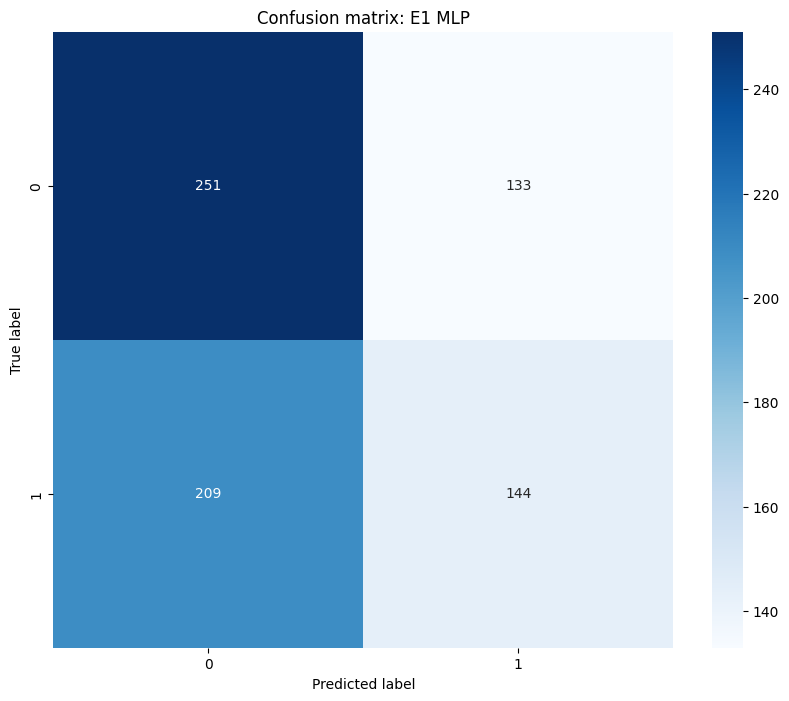

              precision    recall  f1-score   support

           0       0.55      0.65      0.59       384
           1       0.52      0.41      0.46       353

    accuracy                           0.54       737
   macro avg       0.53      0.53      0.53       737
weighted avg       0.53      0.54      0.53       737



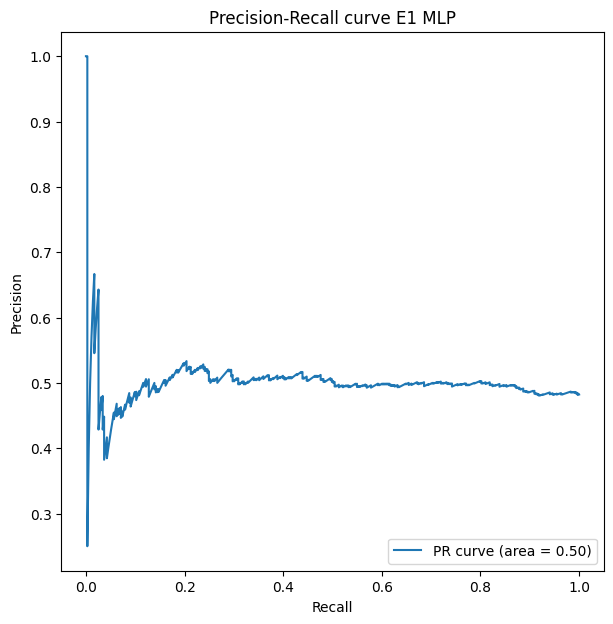

In [699]:
##### EVALUATE MLP #####
# Test labels, X_train = data is already defined earlier
y_test = vote_labels_test

# Predict the classes
y_pred = mlp_vote.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E1 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E1 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 1 - MLP to the results list
stats.append(('1', 'MLP', 'Vote', 'Vote', accuracy, precision, recall, f1, vote_majority))

In [700]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv_svm['speech_svm'],
    train_labels=vote_labels_svm,
    test_labels=vote_labels_svm,
    name='Experiment 1 SVM'
)

# Add the results to the results list
stats.append(('1', 'SVM', 'Vote', 'Vote', accuracy, precision, recall, f1, vote_majority))

### Experiment 2: VADER - VADER

24/24 [==============================] - 1s 5ms/step


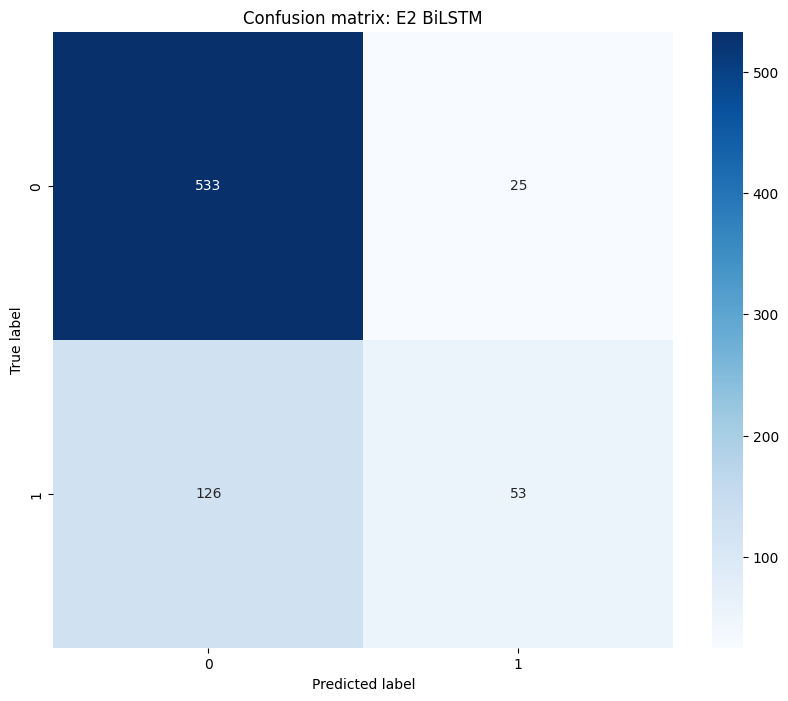

              precision    recall  f1-score   support

           0       0.81      0.96      0.88       558
           1       0.68      0.30      0.41       179

    accuracy                           0.80       737
   macro avg       0.74      0.63      0.64       737
weighted avg       0.78      0.80      0.76       737



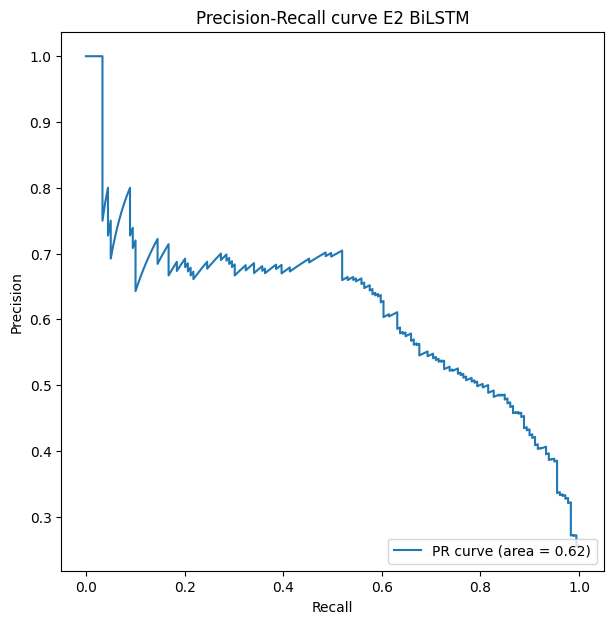

In [701]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_vader.h5')

# Define y test
y_test = vader_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E2 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E2 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 2 - BiLSTM to the results list
stats.append(('2', 'BiLSTM', 'VADER', 'VADER', accuracy, precision, recall, f1, vader_majority))

Epoch 1/10
208/208 [==============================] - 1s 3ms/step - loss: 0.5055 - accuracy: 0.7709
Epoch 2/10
208/208 [==============================] - 1s 3ms/step - loss: 0.4079 - accuracy: 0.8151
Epoch 3/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3721 - accuracy: 0.8281
Epoch 4/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3582 - accuracy: 0.8377
Epoch 5/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3368 - accuracy: 0.8495
Epoch 6/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3240 - accuracy: 0.8574
Epoch 7/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3192 - accuracy: 0.8589
Epoch 8/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3054 - accuracy: 0.8675
Epoch 9/10
208/208 [==============================] - 1s 3ms/step - loss: 0.2968 - accuracy: 0.8720
Epoch 10/10
24/24 [==============================] - 0s 2ms/step


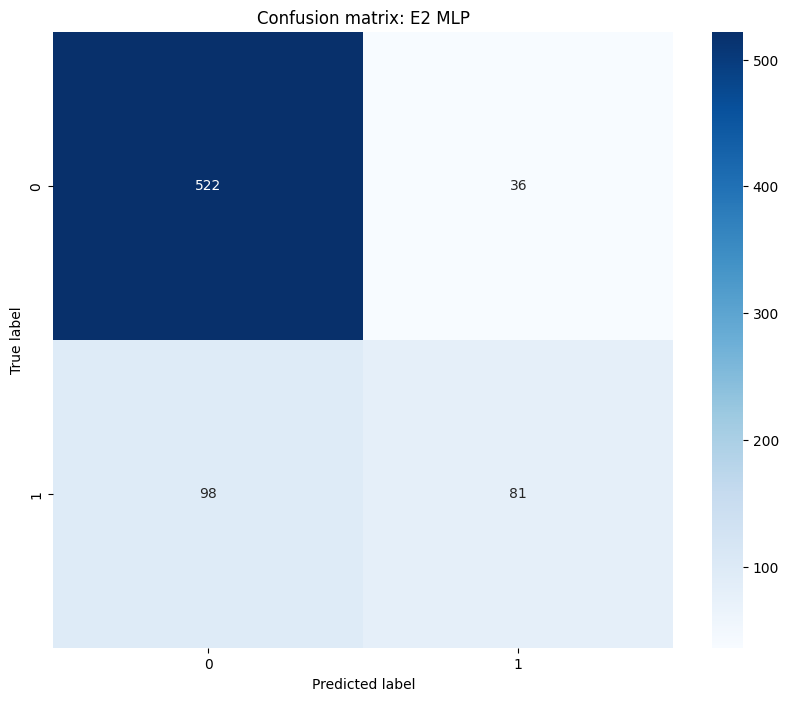

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       558
           1       0.69      0.45      0.55       179

    accuracy                           0.82       737
   macro avg       0.77      0.69      0.72       737
weighted avg       0.81      0.82      0.80       737



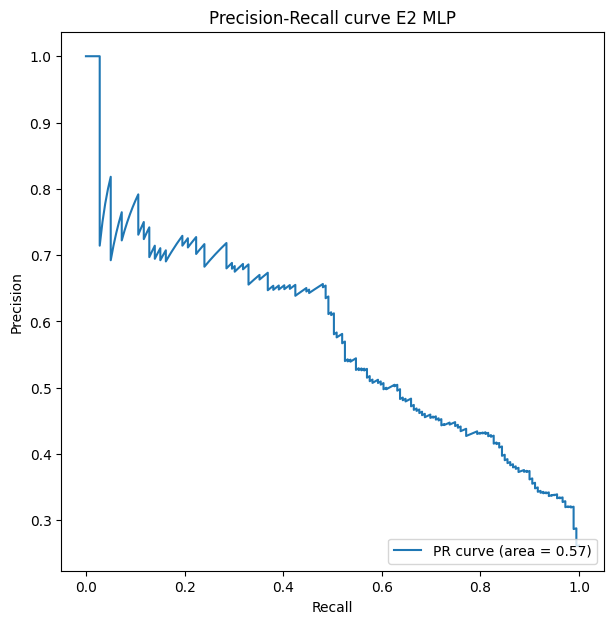

In [702]:
####### train MLP #######
mlp_vader = Sequential([
    Dense(100, input_shape=(data.shape[1],)),  # Hidden layer of 100 nodes
    BatchNormalization(),  # Batch normalization
    Activation('relu'),  # ReLU activation function
    Dropout(0.5),  # Dropout regularization rate of 0.5
    Dense(vader_labels.shape[1], activation='sigmoid')  # Sigmoid activation in the output layer
])

mlp_vader.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_vader.fit(data, vader_labels, batch_size=32, epochs=10, verbose=1)


##### EVALUATE MLP #####
# Test labels, X_train = data is already defined earlier
y_test = vader_labels_test

# Predict the classes
y_pred = mlp_vader.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E2 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E2 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 2 - MLP to the results list
stats.append(('2', 'MLP', 'VADER', 'VADER', accuracy, precision, recall, f1, vader_majority))

In [703]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv_svm['speech_svm'],
    train_labels=vader_labels_svm,
    test_labels=vader_labels_svm,
    name='Experiment 2 SVM'
)

# Add the results to the results list
stats.append(('2', 'SVM', 'VADER', 'VADER', accuracy, precision, recall, f1, vader_majority))

### Experiment 3: VADER - Vote

24/24 [==============================] - 1s 4ms/step


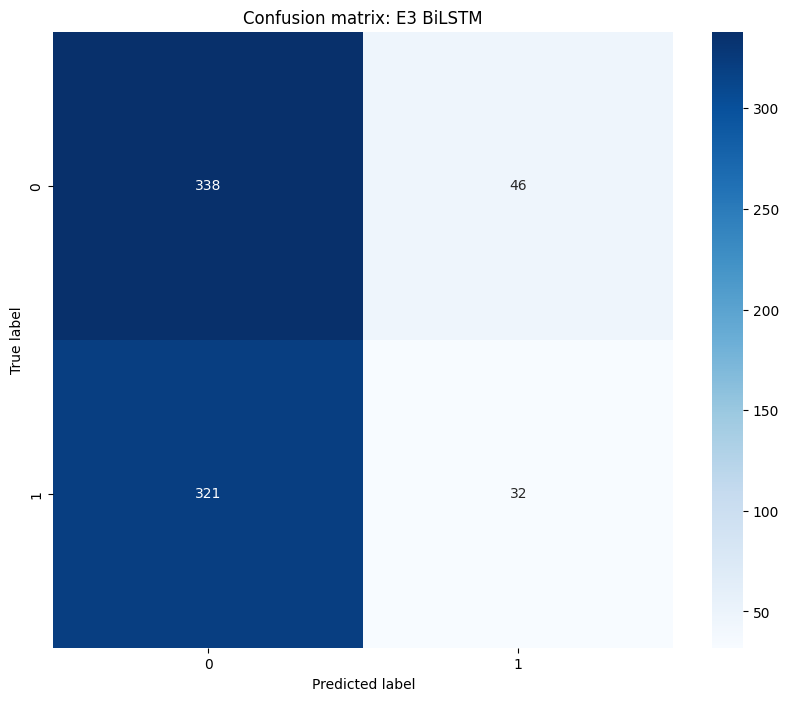

              precision    recall  f1-score   support

           0       0.51      0.88      0.65       384
           1       0.41      0.09      0.15       353

    accuracy                           0.50       737
   macro avg       0.46      0.49      0.40       737
weighted avg       0.46      0.50      0.41       737



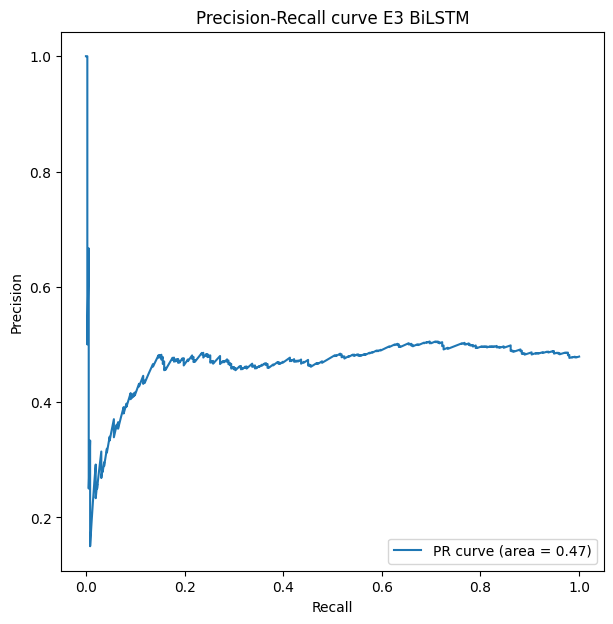

In [704]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_vader_v2.h5')

# Define y test
y_test = vote_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E3 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E3 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list 
stats.append(('3', 'BiLSTM', 'VADER', 'Vote', accuracy, precision, recall, f1, vote_majority))

24/24 [==============================] - 0s 2ms/step


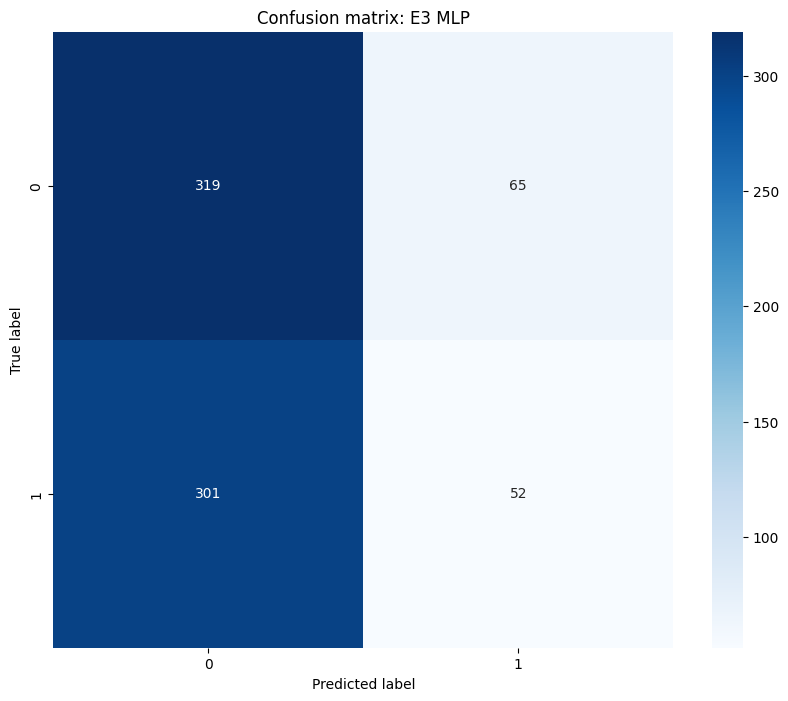

              precision    recall  f1-score   support

           0       0.51      0.83      0.64       384
           1       0.44      0.15      0.22       353

    accuracy                           0.50       737
   macro avg       0.48      0.49      0.43       737
weighted avg       0.48      0.50      0.44       737



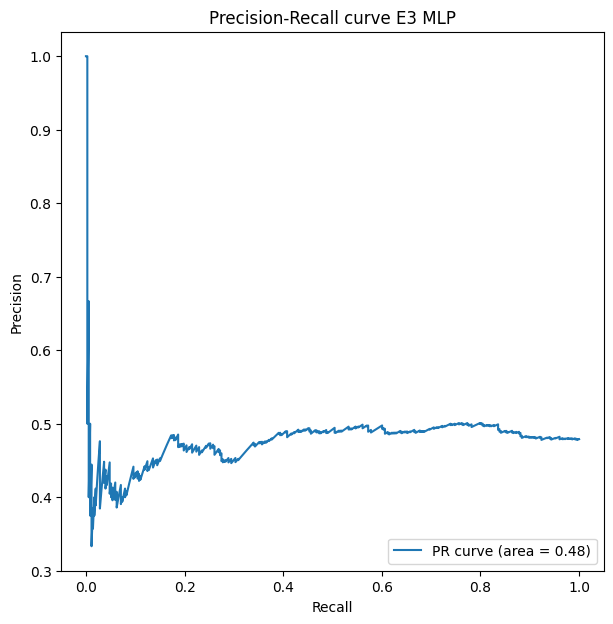

In [705]:
##### EVALUATE MLP #####
# Test labels, X_train = data is already defined earlier
y_test = vote_labels_test

# Predict the classes
y_pred = mlp_vader.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E3 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E3 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list
stats.append(('3', 'MLP', 'VADER', 'Vote', accuracy, precision, recall, f1, vote_majority))

In [706]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv_svm['speech_svm'],
    train_labels=vader_labels_svm,
    test_labels=vote_labels_svm,
    name='Experiment 3 SVM'
)

# Add the results to the results list
stats.append(('3', 'SVM', 'VADER', 'Vote', accuracy, precision, recall, f1, vote_majority))

### Experiment 4: TextBlob - TextBlob

24/24 [==============================] - 2s 4ms/step


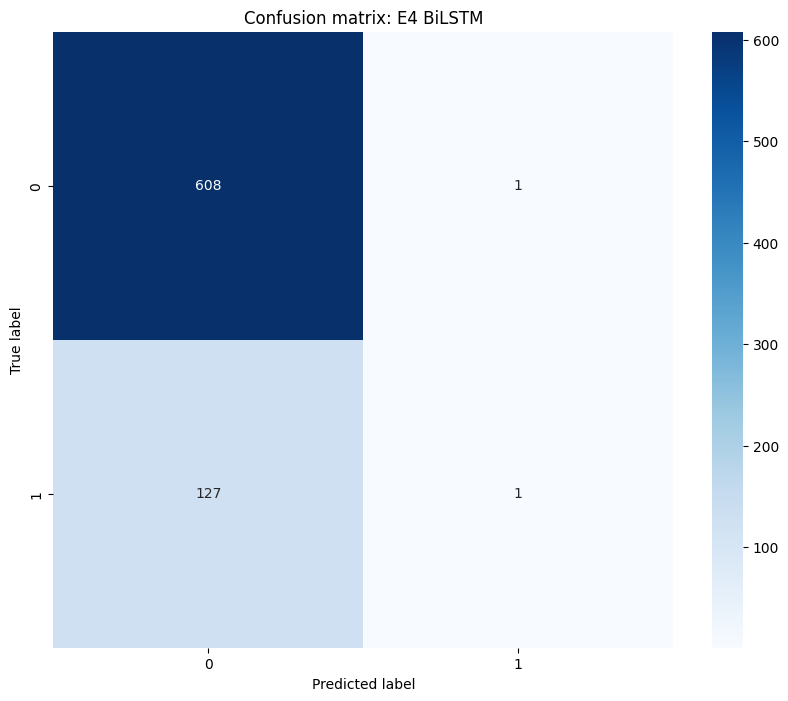

              precision    recall  f1-score   support

           0       0.83      1.00      0.90       609
           1       0.50      0.01      0.02       128

    accuracy                           0.83       737
   macro avg       0.66      0.50      0.46       737
weighted avg       0.77      0.83      0.75       737



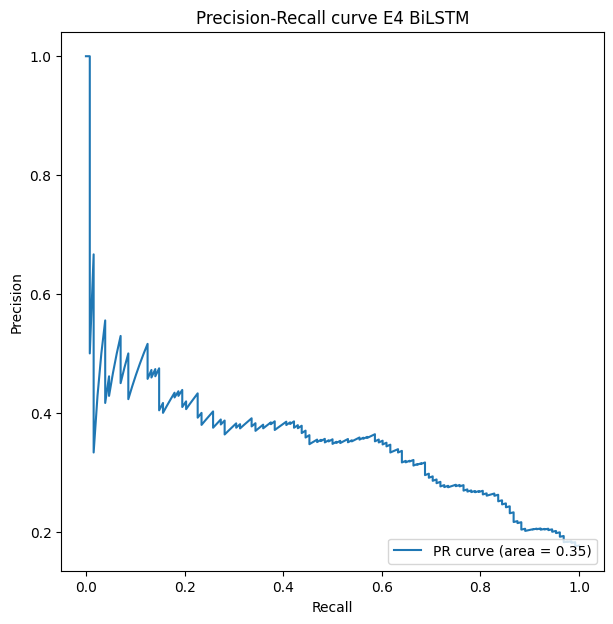

In [707]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_textblob.h5')

# Define y test
y_test = textblob_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E4 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E4 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list
stats.append(('4', 'BiLSTM', 'TextBlob', 'TextBlob', accuracy, precision, recall, f1, textblob_majority))

Epoch 1/10
208/208 [==============================] - 1s 2ms/step - loss: 0.5283 - accuracy: 0.7890
Epoch 2/10
208/208 [==============================] - 1s 3ms/step - loss: 0.4110 - accuracy: 0.8353
Epoch 3/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3850 - accuracy: 0.8438
Epoch 4/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3589 - accuracy: 0.8525
Epoch 5/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3476 - accuracy: 0.8552
Epoch 6/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3410 - accuracy: 0.8590
Epoch 7/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3305 - accuracy: 0.8586
Epoch 8/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3158 - accuracy: 0.8723
Epoch 9/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3136 - accuracy: 0.8697
Epoch 10/10
24/24 [==============================] - 0s 1ms/step


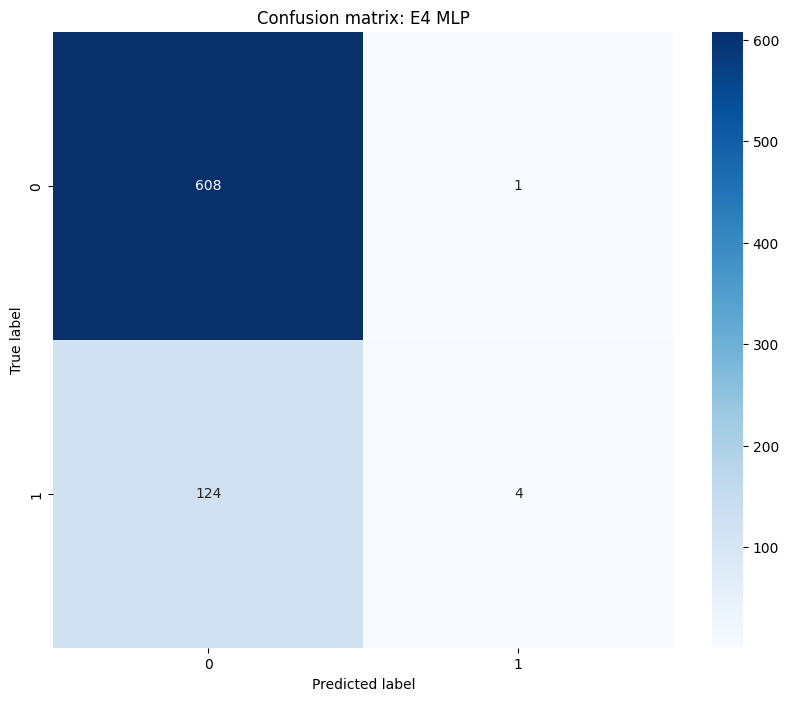

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       609
           1       0.80      0.03      0.06       128

    accuracy                           0.83       737
   macro avg       0.82      0.51      0.48       737
weighted avg       0.83      0.83      0.76       737



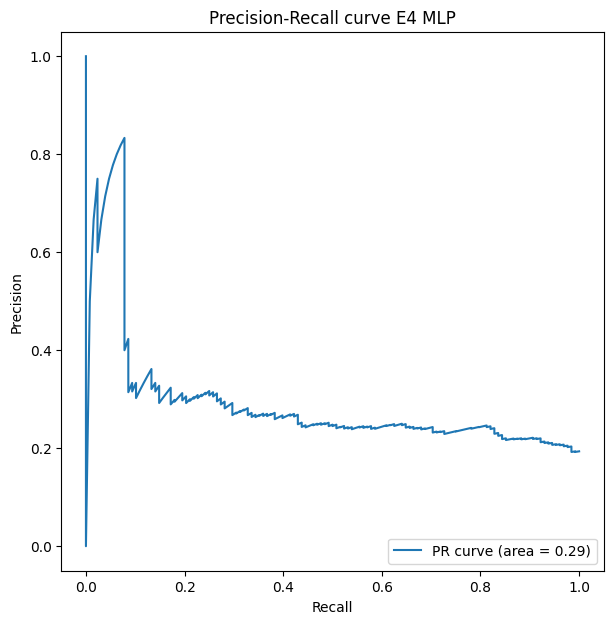

In [708]:
####### train MLP #######
mlp_textblob = Sequential([
    Dense(100, input_shape=(data.shape[1],)),  # Hidden layer of 100 nodes
    BatchNormalization(),  # Batch normalization
    Activation('relu'),  # ReLU activation function
    Dropout(0.5),  # Dropout regularization rate of 0.5
    Dense(textblob_labels.shape[1], activation='sigmoid')  # Sigmoid activation in the output layer
])

mlp_textblob.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_textblob.fit(data, textblob_labels, batch_size=32, epochs=10, verbose=1)


##### EVALUATE MLP #####
# Test labels, X_train = data is already defined earlier
y_test = textblob_labels_test

# Predict the classes
y_pred = mlp_textblob.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E4 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E4 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list 
stats.append(('4', 'MLP', 'TextBlob', 'TextBlob', accuracy, precision, recall, f1, textblob_majority))

In [709]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv_svm['speech_svm'],
    train_labels=textblob_labels_svm,
    test_labels=textblob_labels_svm,
    name='Experiment 4 SVM'
)

# Add the results to the results list
stats.append(('4', 'SVM', 'TextBlob', 'TextBlob', accuracy, precision, recall, f1, textblob_majority))

### Experiment 5: TextBlob - Vote

24/24 [==============================] - 1s 3ms/step


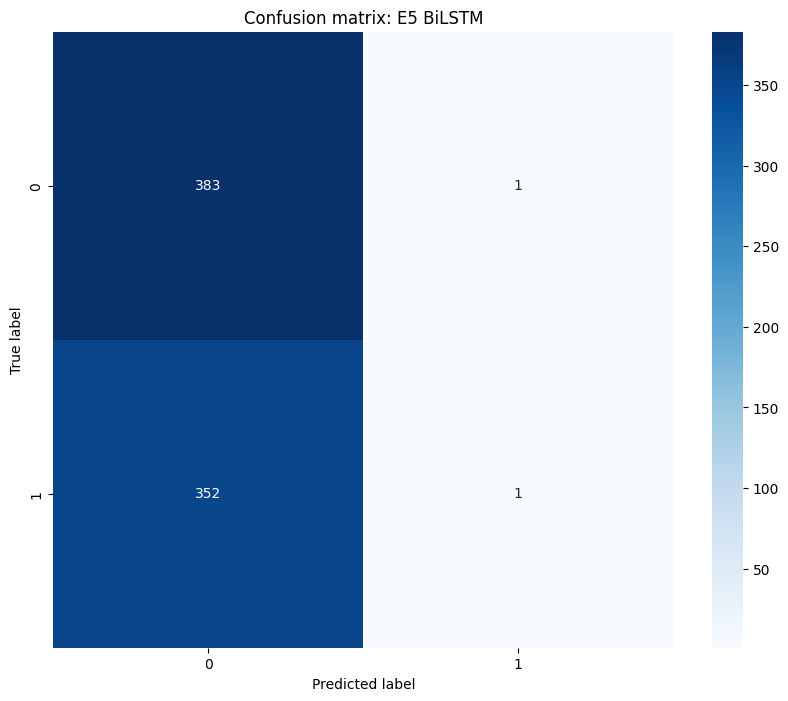

              precision    recall  f1-score   support

           0       0.52      1.00      0.68       384
           1       0.50      0.00      0.01       353

    accuracy                           0.52       737
   macro avg       0.51      0.50      0.35       737
weighted avg       0.51      0.52      0.36       737



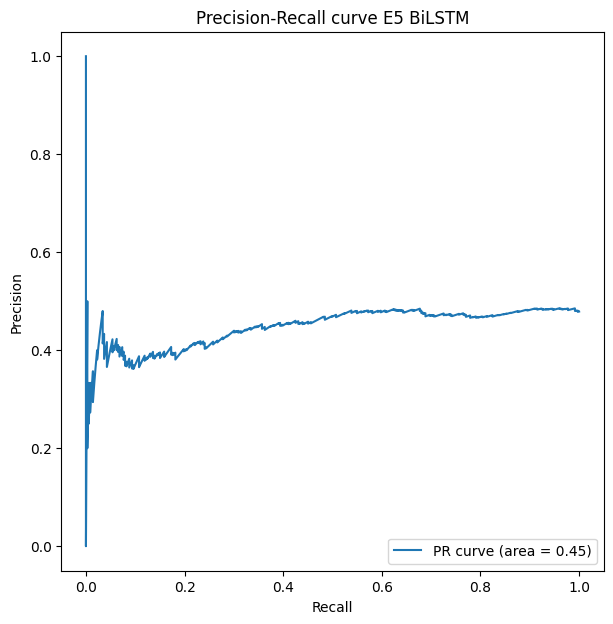

In [710]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_textblob_v2.h5')

# Define y_test
y_test = vote_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E5 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E5 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list
stats.append(('5', 'BiLSTM', 'TextBlob', 'Vote', accuracy, precision, recall, f1, vote_majority))

24/24 [==============================] - 0s 1ms/step


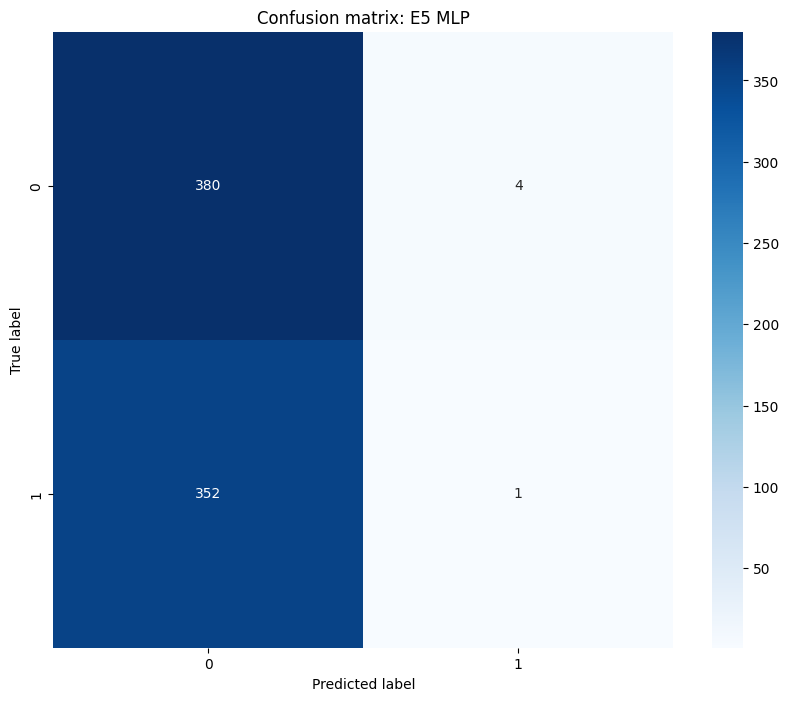

              precision    recall  f1-score   support

           0       0.52      0.99      0.68       384
           1       0.20      0.00      0.01       353

    accuracy                           0.52       737
   macro avg       0.36      0.50      0.34       737
weighted avg       0.37      0.52      0.36       737



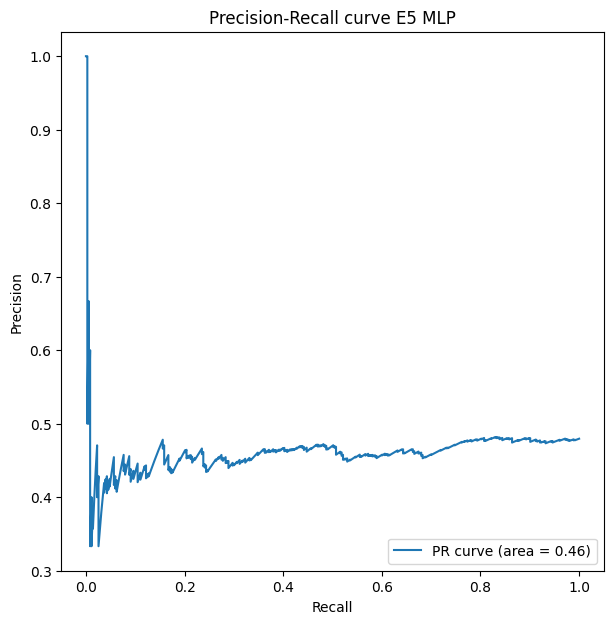

In [711]:
##### EVALUATE MLP #####
# Test labels, X_train = data is already defined earlier
y_test = vote_labels_test

# Predict the classes
y_pred = mlp_textblob.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E5 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E5 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list 
stats.append(('5', 'MLP', 'TextBlob', 'Vote', accuracy, precision, recall, f1, vote_majority))

In [712]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv_svm['speech_svm'],
    train_labels=textblob_labels_svm,
    test_labels=vote_labels_svm,
    name='Experiment 5 SVM'
)

# Add the results to the results list
stats.append(('5', 'SVM', 'TextBlob', 'Vote', accuracy, precision, recall, f1, vote_majority))

### Experiment 6

24/24 [==============================] - 1s 4ms/step


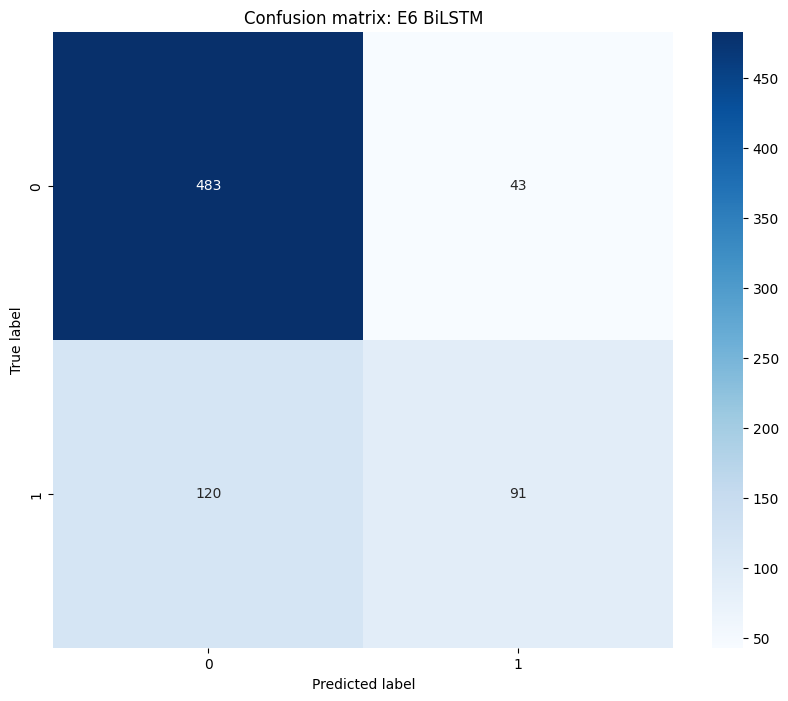

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       526
           1       0.68      0.43      0.53       211

    accuracy                           0.78       737
   macro avg       0.74      0.67      0.69       737
weighted avg       0.77      0.78      0.76       737



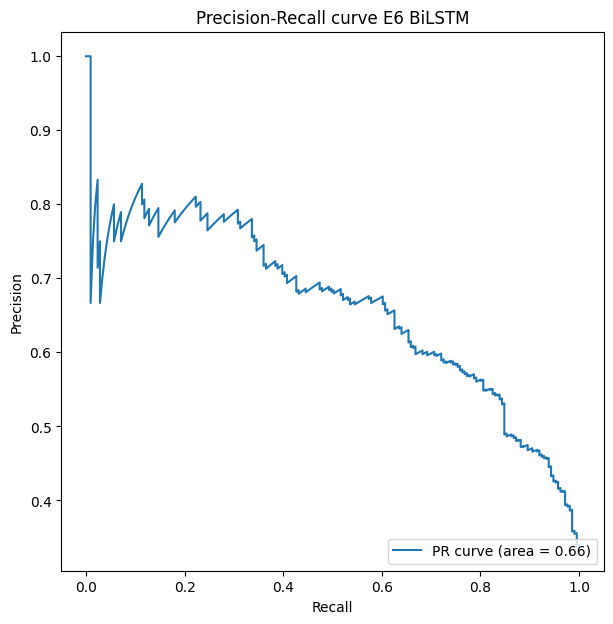

In [713]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_afinn.h5')

# Definine y_test
y_test = afinn_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E6 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E6 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list
stats.append(('6', 'BiLSTM', 'AFINN', 'AFINN', accuracy, precision, recall, f1, afinn_majority))

Epoch 1/10
208/208 [==============================] - 1s 2ms/step - loss: 0.6356 - accuracy: 0.7140
Epoch 2/10
208/208 [==============================] - 1s 3ms/step - loss: 0.4578 - accuracy: 0.7829
Epoch 3/10
208/208 [==============================] - 1s 3ms/step - loss: 0.4122 - accuracy: 0.8032
Epoch 4/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3921 - accuracy: 0.8168
Epoch 5/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3647 - accuracy: 0.8350
Epoch 6/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3517 - accuracy: 0.8359
Epoch 7/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3500 - accuracy: 0.8450
Epoch 8/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3323 - accuracy: 0.8586
Epoch 9/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3165 - accuracy: 0.8625
Epoch 10/10
24/24 [==============================] - 0s 2ms/step


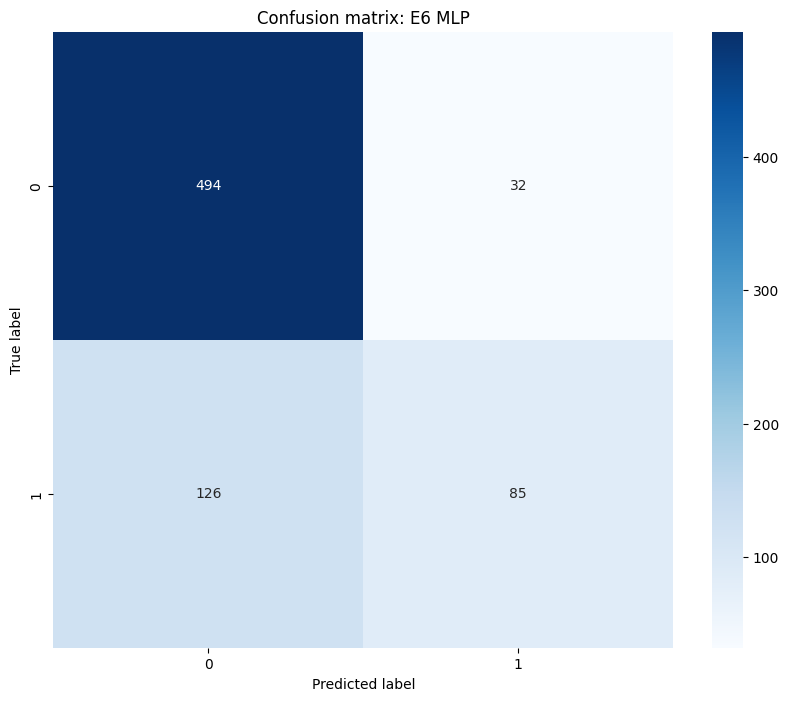

              precision    recall  f1-score   support

           0       0.80      0.94      0.86       526
           1       0.73      0.40      0.52       211

    accuracy                           0.79       737
   macro avg       0.76      0.67      0.69       737
weighted avg       0.78      0.79      0.76       737



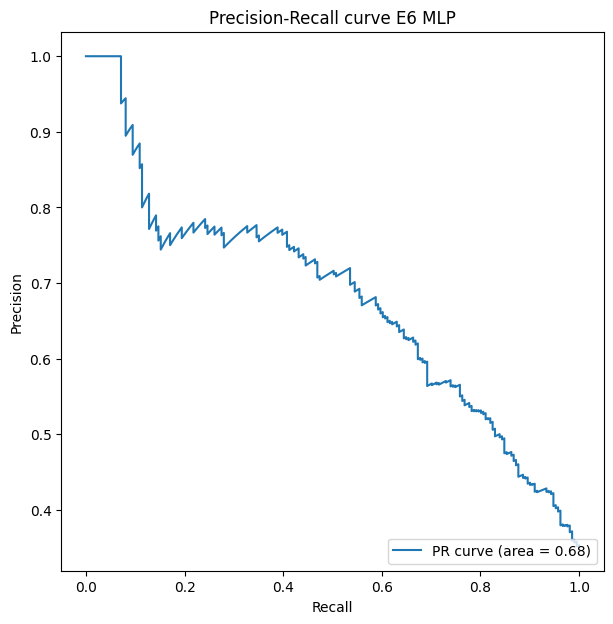

In [714]:
####### train MLP #######
mlp_afinn = Sequential([
    Dense(100, input_shape=(data.shape[1],)),  # Hidden layer of 100 nodes
    BatchNormalization(),  # Batch normalization
    Activation('relu'),  # ReLU activation function
    Dropout(0.5),  # Dropout regularization rate of 0.5
    Dense(afinn_labels.shape[1], activation='sigmoid')  # Sigmoid activation in the output layer
])

mlp_afinn.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_afinn.fit(data, afinn_labels, batch_size=32, epochs=10, verbose=1)


##### EVALUATE MLP #####
# Test labels, X_train = data is already defined earlier
y_test = afinn_labels_test

# Predict the classes
y_pred = mlp_afinn.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E6 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E6 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list
stats.append(('6', 'MLP', 'AFINN', 'AFINN', accuracy, precision, recall, f1, afinn_majority))

In [715]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv_svm['speech_svm'],
    train_labels=afinn_labels_svm,
    test_labels=afinn_labels_svm,
    name='Experiment 6 SVM'
)

# Add the results to the results list
stats.append(('6', 'SVM', 'AFINN', 'AFINN', accuracy, precision, recall, f1, afinn_majority))

### Experiment 7: AFINN - Vote

24/24 [==============================] - 1s 3ms/step


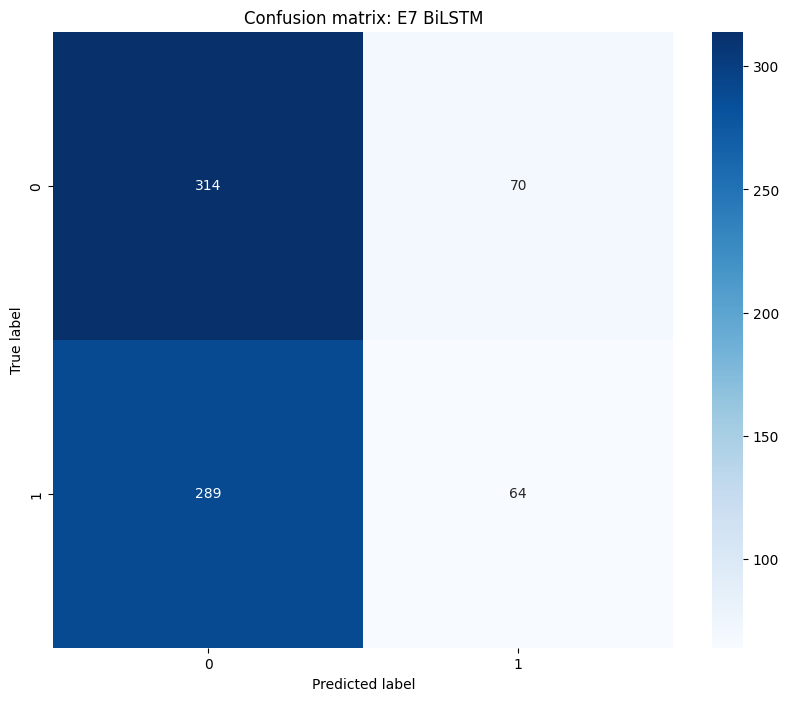

              precision    recall  f1-score   support

           0       0.52      0.82      0.64       384
           1       0.48      0.18      0.26       353

    accuracy                           0.51       737
   macro avg       0.50      0.50      0.45       737
weighted avg       0.50      0.51      0.46       737



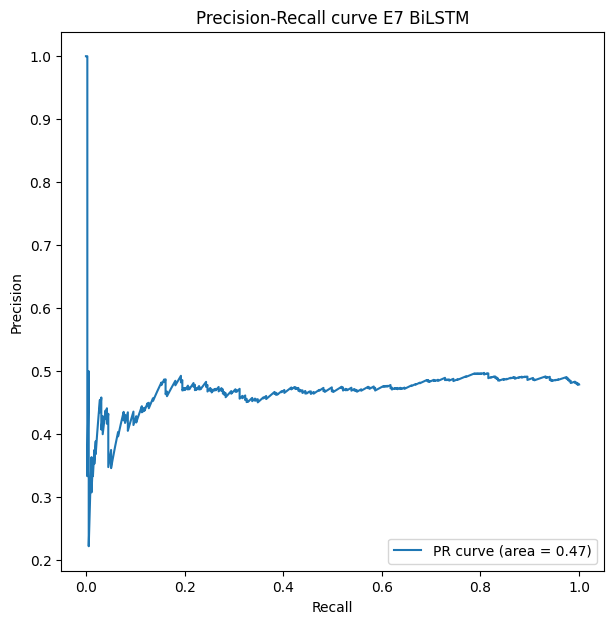

In [716]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_afinn_v2.h5')

# Define y_test
y_test = vote_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E7 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E7 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 7 - BiLSTM to the results list 
stats.append(('7', 'BiLSTM', 'AFINN', 'Vote', accuracy, precision, recall, f1, vote_majority))

24/24 [==============================] - 0s 2ms/step


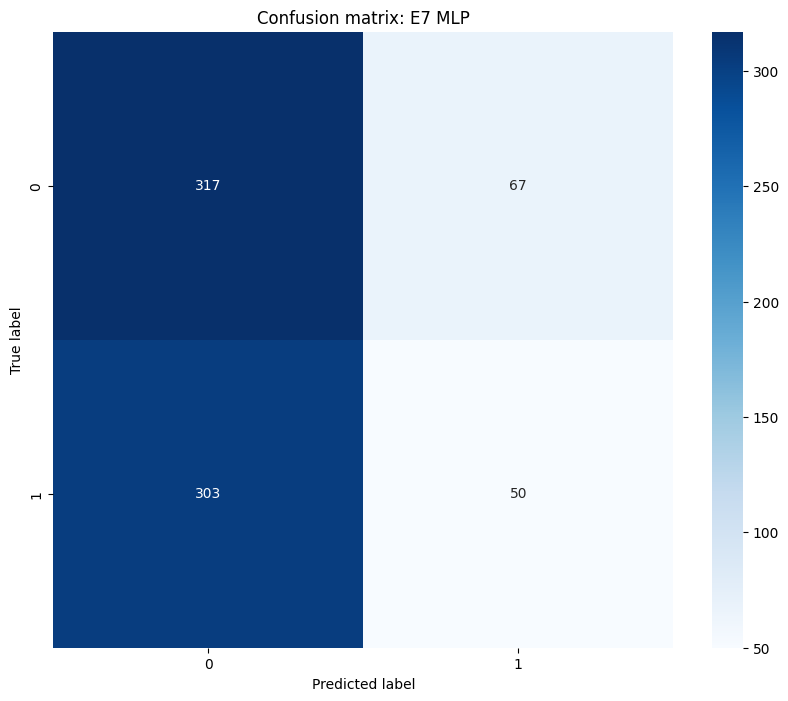

              precision    recall  f1-score   support

           0       0.51      0.83      0.63       384
           1       0.43      0.14      0.21       353

    accuracy                           0.50       737
   macro avg       0.47      0.48      0.42       737
weighted avg       0.47      0.50      0.43       737



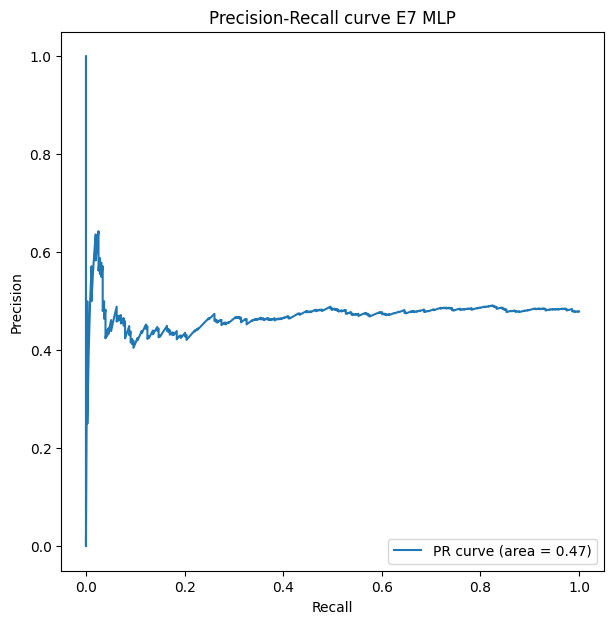

In [717]:
##### EVALUATE MLP #####
# Test labels, X_train = data is already defined earlier
y_test = vote_labels_test

# Predict the classes
y_pred = mlp_afinn.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E7 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E7 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 7 - MLP to the results list 
stats.append(('7', 'MLP', 'AFINN', 'Vote', accuracy, precision, recall, f1, vote_majority))

In [718]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv_svm['speech_svm'],
    train_labels=afinn_labels_svm,
    test_labels=vote_labels_svm,
    name='Experiment 7 SVM'
)

# Add the results to the results list
stats.append(('7', 'SVM', 'AFINN', 'Vote', accuracy, precision, recall, f1, vote_majority))

## Experiment 8

24/24 [==============================] - 1s 8ms/step


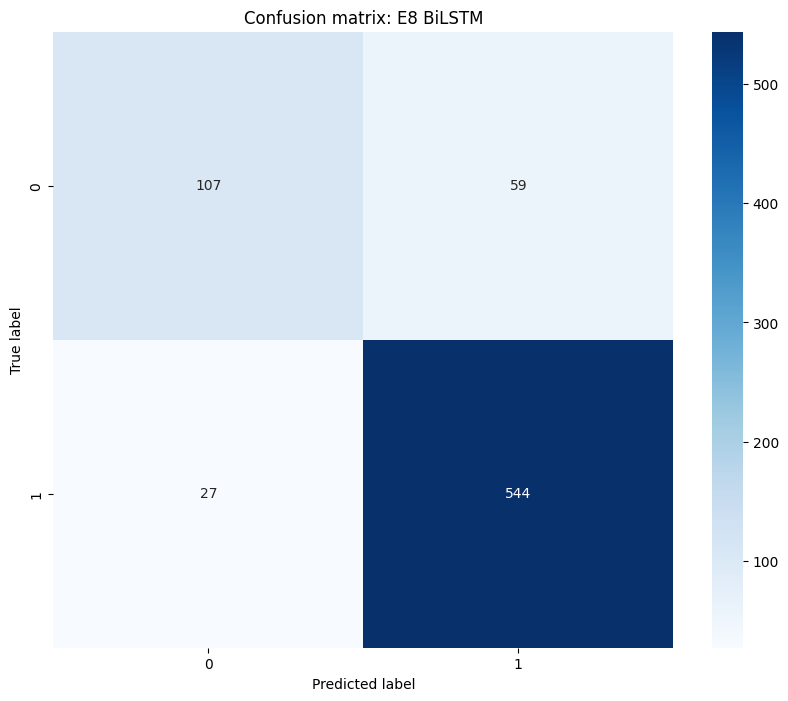

              precision    recall  f1-score   support

           0       0.80      0.64      0.71       166
           1       0.90      0.95      0.93       571

    accuracy                           0.88       737
   macro avg       0.85      0.80      0.82       737
weighted avg       0.88      0.88      0.88       737



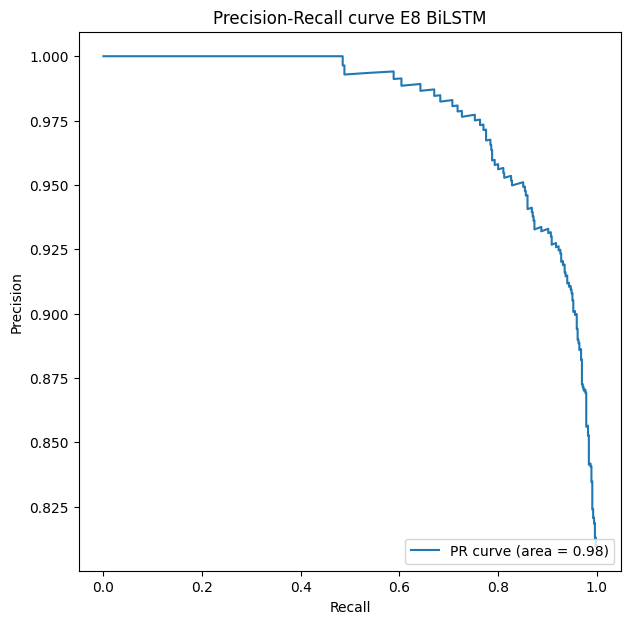

In [719]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_domain.h5')

# Define y_test
y_test = domain_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E8 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E8 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 8 - Domain to the results list 
stats.append(('8', 'BiLSTM', 'Domain', 'Domain', accuracy, precision, recall, f1, domain_majority))

Epoch 1/10
208/208 [==============================] - 1s 2ms/step - loss: 0.4363 - accuracy: 0.7989
Epoch 2/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3019 - accuracy: 0.8658
Epoch 3/10
208/208 [==============================] - 1s 2ms/step - loss: 0.2711 - accuracy: 0.8805
Epoch 4/10
208/208 [==============================] - 1s 3ms/step - loss: 0.2525 - accuracy: 0.8853
Epoch 5/10
208/208 [==============================] - 1s 3ms/step - loss: 0.2396 - accuracy: 0.8921
Epoch 6/10
208/208 [==============================] - 1s 3ms/step - loss: 0.2311 - accuracy: 0.8990
Epoch 7/10
208/208 [==============================] - 1s 2ms/step - loss: 0.2202 - accuracy: 0.9049
Epoch 8/10
208/208 [==============================] - 1s 2ms/step - loss: 0.2168 - accuracy: 0.9057
Epoch 9/10
208/208 [==============================] - 1s 3ms/step - loss: 0.2043 - accuracy: 0.9093
Epoch 10/10
24/24 [==============================] - 0s 2ms/step


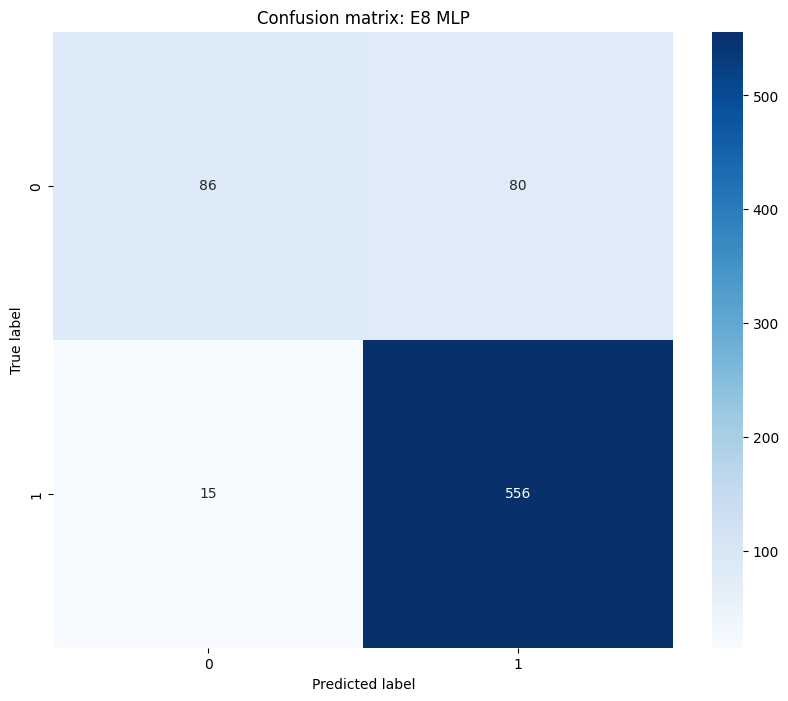

              precision    recall  f1-score   support

           0       0.85      0.52      0.64       166
           1       0.87      0.97      0.92       571

    accuracy                           0.87       737
   macro avg       0.86      0.75      0.78       737
weighted avg       0.87      0.87      0.86       737



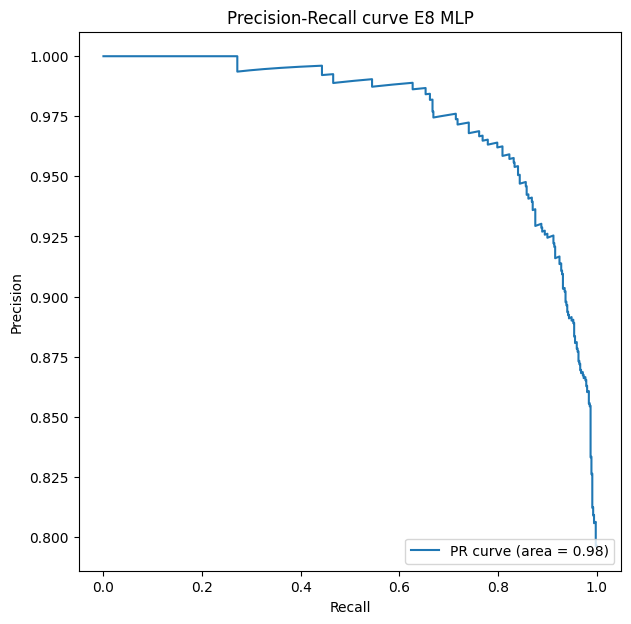

In [720]:
####### train MLP #######
mlp_domain = Sequential([
    Dense(100, input_shape=(data.shape[1],)),  # Hidden layer of 100 nodes
    BatchNormalization(),  # Batch normalization
    Activation('relu'),  # ReLU activation function
    Dropout(0.5),  # Dropout regularization rate of 0.5
    Dense(domain_labels.shape[1], activation='sigmoid')  # Sigmoid activation in the output layer
])

mlp_domain.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_domain.fit(data, domain_labels, batch_size=32, epochs=10, verbose=1)


##### EVALUATE MLP #####
# Test labels, X_train = data is already defined earlier
y_test = domain_labels_test

# Predict the classes
y_pred = mlp_domain.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E8 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E8 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 8 - MLP to the results list
stats.append(('8', 'MLP', 'Domain', 'Domain', accuracy, precision, recall, f1, domain_majority))

In [721]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv_svm['speech_svm'],
    train_labels=domain_labels_svm,
    test_labels=domain_labels_svm,
    name='Experiment 8 SVM'
)

# Add the results to the results list
stats.append(('8', 'SVM', 'Domain', 'Domain', accuracy, precision, recall, f1, domain_majority))

### Experiment 9: Domain - Vote

24/24 [==============================] - 1s 9ms/step


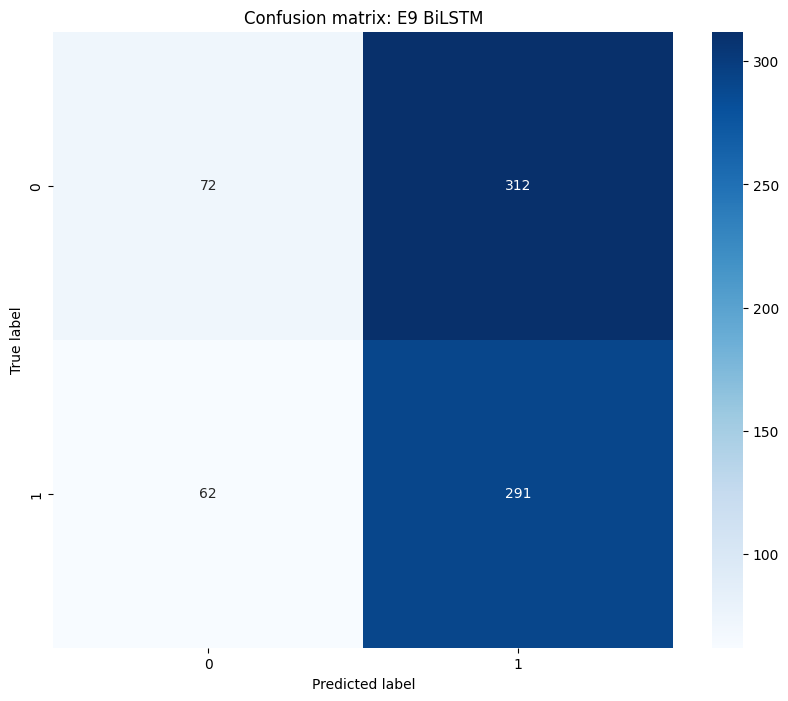

              precision    recall  f1-score   support

           0       0.54      0.19      0.28       384
           1       0.48      0.82      0.61       353

    accuracy                           0.49       737
   macro avg       0.51      0.51      0.44       737
weighted avg       0.51      0.49      0.44       737



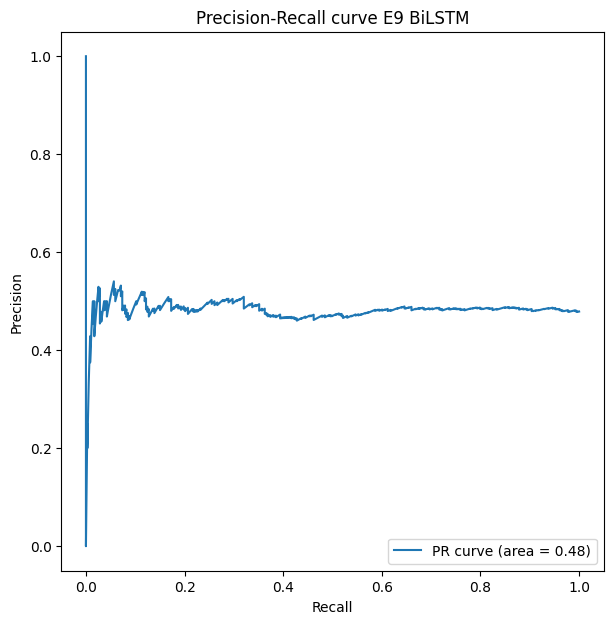

In [722]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_domain_v2.h5')

# Define y_test
y_test = vote_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E9 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E9 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 9 - BiLSTM to the results list 
stats.append(('9', 'BiLSTM', 'Domain', 'Vote', accuracy, precision, recall, f1, vote_majority))

24/24 [==============================] - 0s 2ms/step


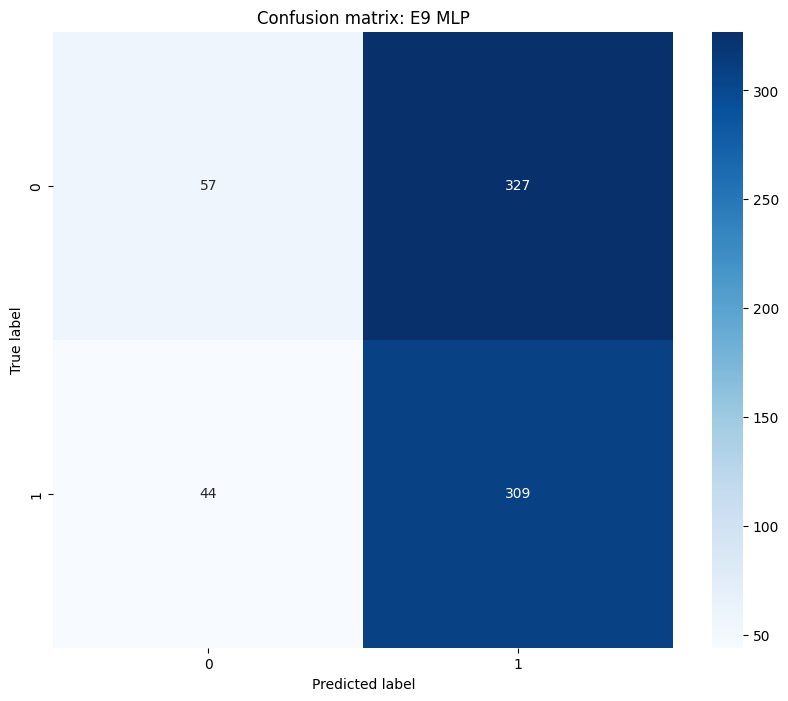

              precision    recall  f1-score   support

           0       0.56      0.15      0.24       384
           1       0.49      0.88      0.62       353

    accuracy                           0.50       737
   macro avg       0.53      0.51      0.43       737
weighted avg       0.53      0.50      0.42       737



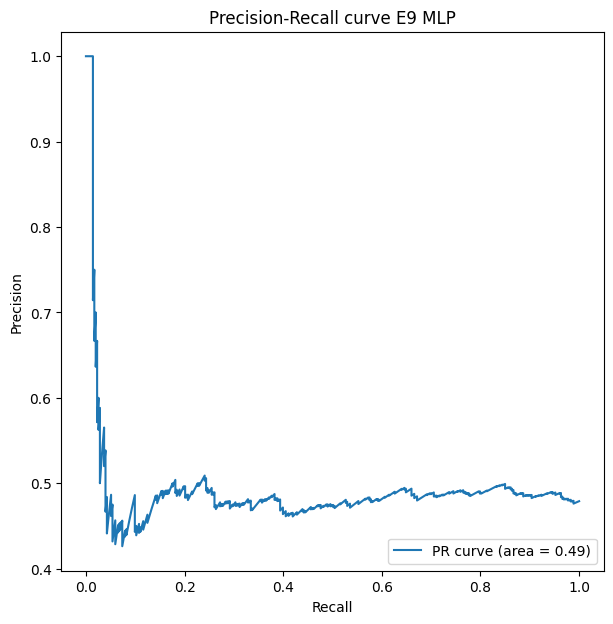

In [723]:
##### EVALUATE MLP #####
# Test labels, X_train = data is already defined earlier
y_test = vote_labels_test

# Predict the classes
y_pred = mlp_domain.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E9 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E9 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 7 - MLP to the results list 
stats.append(('9', 'MLP', 'Domain', 'Vote', accuracy, precision, recall, f1, vote_majority))

In [724]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv_svm['speech_svm'],
    train_labels=domain_labels_svm,
    test_labels=vote_labels_svm,
    name='Experiment 6 SVM'
)

# Add the results to the results list
stats.append(('9', 'SVM', 'Domain', 'Vote', accuracy, precision, recall, f1, vote_majority))

SAVE RESULTS

In [725]:
## Write the results to the CSV file
with open(filename, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    writer.writerows(stats)

In [726]:
ff2 = pd.read_csv('hpo_experiment_results.csv')
ff2

,Experiment,Model,Train label,Test label,Accuracy,Precision,Recall,F1,Majority baseline,Run
0,1,BiLSTM,Vote,Vote,0.56645056726094,0.5648255685042621,0.56645056726094,0.5648156815765015,0.5299837925445705,1.0
1,1,MLP,Vote,Vote,0.5526742301458671,0.554106352830666,0.5526742301458671,0.5077296479249572,0.5299837925445705,1.0
2,1,SVM,Vote,Vote,0.5113452188006483,0.48067226890756304,0.49310344827586206,0.4868085106382979,0.5299837925445705,1.0
3,2,BiLSTM,VADER,VADER,0.8184764991896273,0.8050964061835996,0.8184764991896273,0.8069843692927361,0.7690437601296597,1.0
4,2,MLP,VADER,VADER,0.8095623987034035,0.7935547901818906,0.8095623987034035,0.795445415708773,0.7690437601296597,1.0
...,...,...,...,...,...,...,...,...,...,...
131,8,MLP,Domain,Domain,0.8710990502035278,0.8690944847793707,0.8710990502035278,0.8588796806200983,0.7747625508819539,NaN
132,8,SVM,Domain,Domain,0.6255088195386703,0.7736549165120594,0.7302977232924693,0.7513513513513513,0.7747625508819539,NaN
133,9,BiLSTM,Domain,Vote,0.4925373134328358,0.51110121036608,0.4925373134328358,0.4364324401481711,0.5210312075983717,NaN
134,9,MLP,Domain,Vote,0.4966078697421981,0.5267538511102589,0.4966078697421981,0.4217641493092597,0.5210312075983717,NaN


Confidence interval

In [727]:
combined_df['best_param']

model     original_index
vote      0                 {"lstm_units": 64, "learning_rate": 0.00315179...
vader     0                 {"lstm_units": 128, "learning_rate": 4.0280553...
textblob  0                 {"lstm_units": 128, "learning_rate": 0.0050913...
afinn     0                 {"lstm_units": 64, "learning_rate": 0.00980714...
domain    0                 {"lstm_units": 512, "dense_units": 512, "learn...
Name: best_param, dtype: object

In [728]:
pv_test.shape

(737, 30)

In [729]:
pv_val.shape

(1525, 30)

In [730]:
###### BREAK #########
if 1 == 1:
    raise ValueError("Stopping execution at this cell")

ValueError: Stopping execution at this cell

In [756]:
# Set the display option
pd.set_option('display.max_rows', None)

# Print your DataFrame
experiment_results = pd.read_csv('hpo_experiment_results.csv')
experiment_results

,Experiment,Model,Train label,Test label,Accuracy,Precision,Recall,F1,Majority baseline,Run
0,1,BiLSTM,Vote,Vote,0.56645056726094,0.5648255685042621,0.56645056726094,0.5648156815765015,0.5299837925445705,1
1,1,MLP,Vote,Vote,0.5526742301458671,0.554106352830666,0.5526742301458671,0.5077296479249572,0.5299837925445705,1
2,1,SVM,Vote,Vote,0.5113452188006483,0.48067226890756304,0.49310344827586206,0.4868085106382979,0.5299837925445705,1
3,2,BiLSTM,VADER,VADER,0.8184764991896273,0.8050964061835996,0.8184764991896273,0.8069843692927361,0.7690437601296597,1
4,2,MLP,VADER,VADER,0.8095623987034035,0.7935547901818906,0.8095623987034035,0.795445415708773,0.7690437601296597,1
5,2,SVM,VADER,VADER,0.6158833063209076,0.22287390029325513,0.26666666666666666,0.2428115015974441,0.7690437601296597,1
6,3,BiLSTM,VADER,Vote,0.506482982171799,0.4779935003994036,0.506482982171799,0.4428828002721015,0.5299837925445705,1
7,3,MLP,VADER,Vote,0.5089141004862237,0.48038290631924846,0.5089141004862237,0.44168024484047885,0.5299837925445705,1
8,3,SVM,VADER,Vote,0.5162074554294975,0.4750733137829912,0.2793103448275862,0.35179153094462545,0.5299837925445705,1
9,4,BiLSTM,TextBlob,TextBlob,0.8379254457050244,0.8371850236776669,0.8379254457050244,0.7686248846682557,0.8346839546191248,1


In [ ]:
pd.reset_option('display.max_rows')

Calculate confidence intervals

In [ ]:
import pandas as pd

def calculate_conf_interval(data, metric_name='', confidence=0.95):
    """Calculate the confidence interval"""
    n = len(data)
    mean = np.mean(data)
    std_err = sem(data)
    interval = std_err * t.ppf((1 + confidence) / 2., n - 1)

    print(f"Confidence interval for {metric_name}:")
    print("Mean:", mean)
    print("Lower:", mean - interval)
    print("Upper:", mean + interval)

    return pd.Series([mean, mean - interval, mean + interval], index=['mean', 'lower', 'upper'])

# Set dataframe
df = pd.read_csv('hpo_experiment_results_nd.csv')

grouped = df.groupby(['Experiment', 'Model'])

# Create a dictionary to hold the lists
metric_lists = {}

for name, group in grouped:
    exp_number, model = name
    model = model.lower()  # Convert to lower case for consistency
    
    # Create the keys for the dictionary
    acc_key = f"{exp_number}_{model}_acc"
    prec_key = f"{exp_number}_{model}_prec"
    rec_key = f"{exp_number}_{model}_rec"
    f1_key = f"{exp_number}_{model}_f1"
    majority_key = f"{exp_number}_{model}_maj"
    
    # Assign the lists to the dictionary keys
    metric_lists[acc_key] = group['Accuracy'].tolist()
    metric_lists[prec_key] = group['Precision'].tolist()
    metric_lists[rec_key] = group['Recall'].tolist()
    metric_lists[f1_key] = group['F1'].tolist()
    metric_lists[majority_key] = group['Majority baseline'].tolist()

def calculate_and_print_all_intervals(metric_lists):
    df_list = []
    for metric_name, data in metric_lists.items():
        conf_interval = calculate_conf_interval(data, metric_name)
        conf_interval_df = pd.DataFrame(conf_interval).T
        conf_interval_df['metric_name'] = metric_name
        df_list.append(conf_interval_df)

    final_df = pd.concat(df_list, ignore_index=True)
    return final_df

# Call the function
final_df = calculate_and_print_all_intervals(metric_lists)


In [766]:
import pandas as pd

# Load the Excel data into a DataFrame
df = pd.read_excel('Intervals.xlsx', sheet_name='new_data')

In [767]:
# Select only the columns with 'mean' metrics
df = df[['Experiment', 'Model', 'Train label', 'Test label', 
         'Accuracy_mean', 'Precision_mean', 'Recall_mean', 
         'F1_mean', 'Majority baseline_mean']]

# Round to three decimal places
df = df.round(3)

# Convert DataFrame to LaTeX
latex_table = df.to_latex(index=False)

print(latex_table)

\begin{tabular}{rlllrrrrr}
\toprule
 Experiment &  Model & Train label & Test label &  Accuracy\_mean &  Precision\_mean &  Recall\_mean &  F1\_mean &  Majority baseline\_mean \\
\midrule
          1 & BiLSTM &        Vote &       Vote &          0.544 &           0.530 &        0.544 &    0.516 &                   0.542 \\
          1 &    MLP &        Vote &       Vote &          0.545 &           0.548 &        0.545 &    0.531 &                   0.542 \\
          1 &    SVM &        Vote &       Vote &          0.496 &           0.451 &        0.466 &    0.458 &                   0.542 \\
          2 & BiLSTM &       VADER &      VADER &          0.818 &           0.806 &        0.818 &    0.800 &                   0.766 \\
          2 &    MLP &       VADER &      VADER &          0.816 &           0.809 &        0.816 &    0.807 &                   0.766 \\
          2 &    SVM &       VADER &      VADER &          0.626 &           0.238 &        0.271 &    0.253 &            

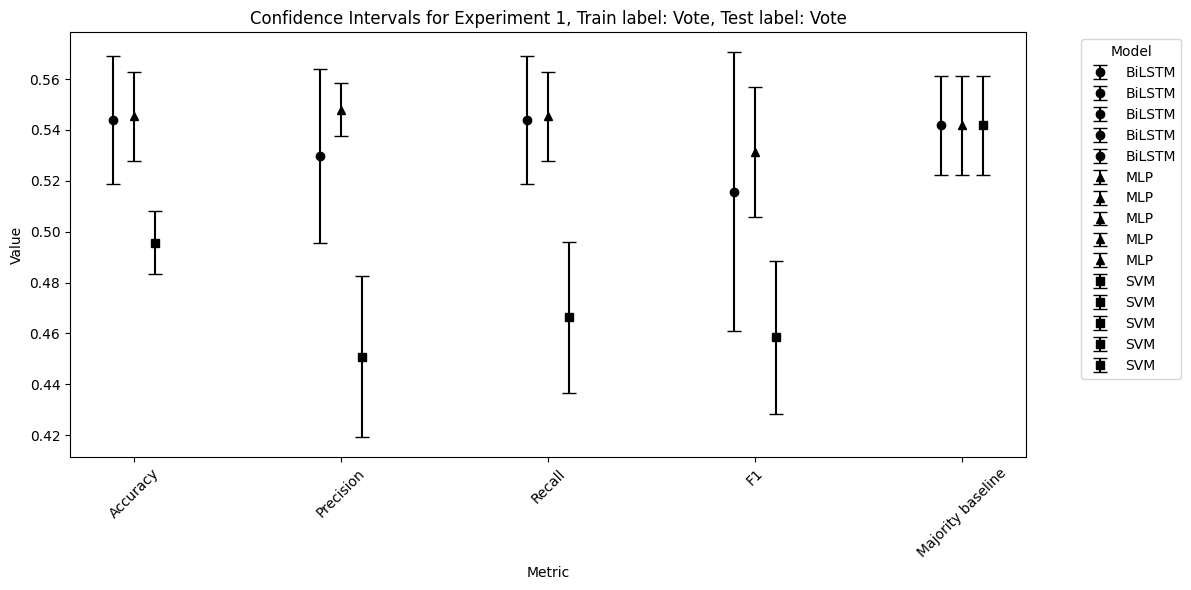

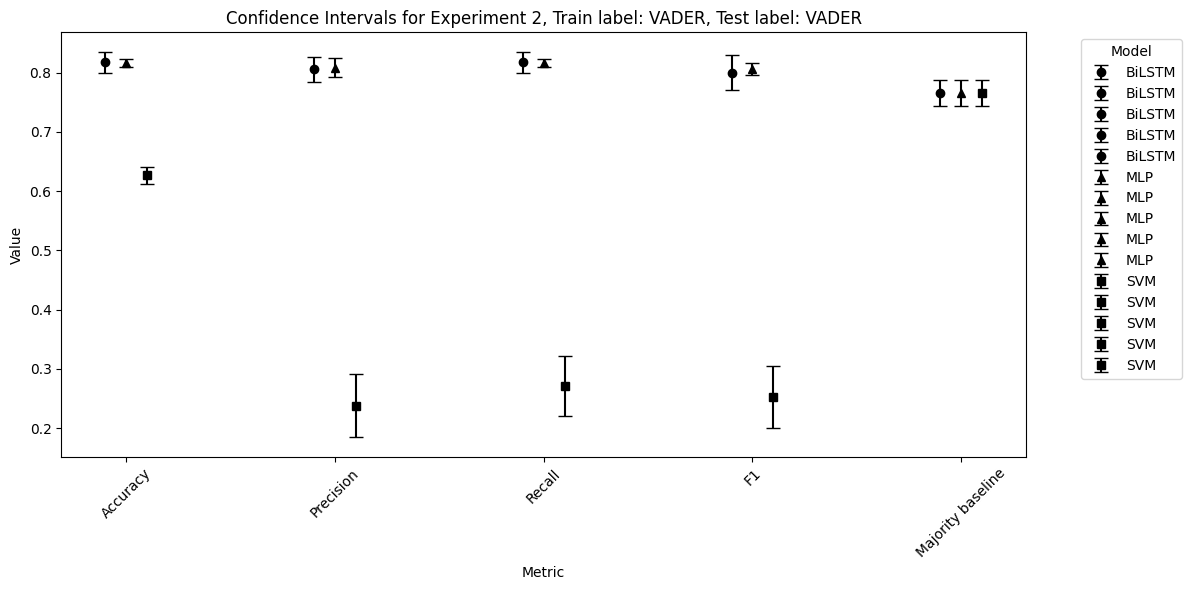

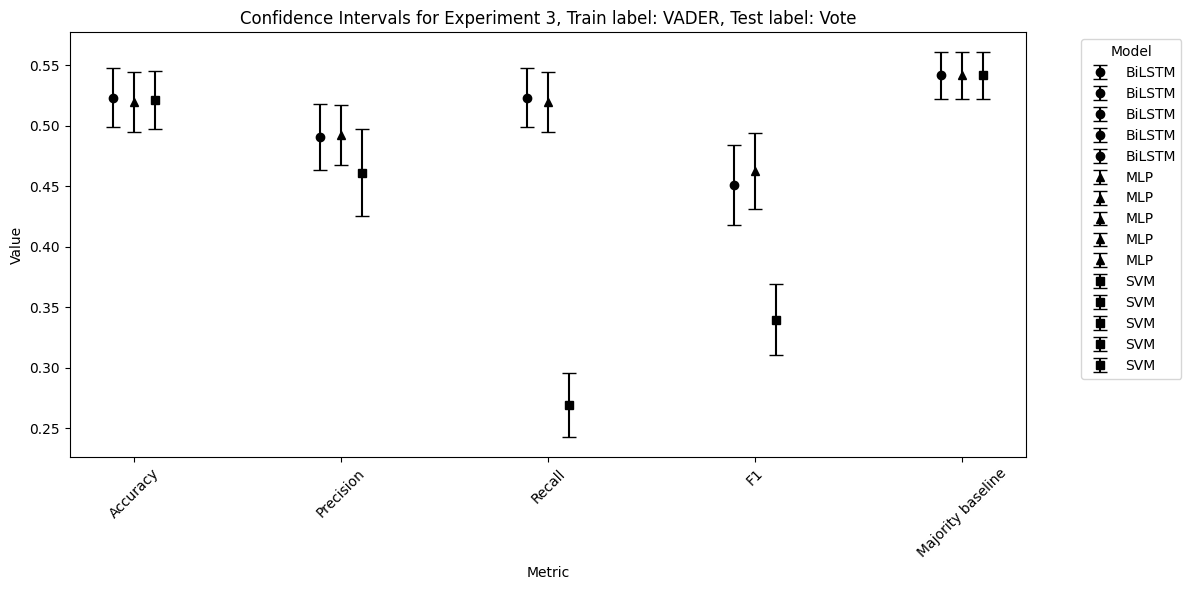

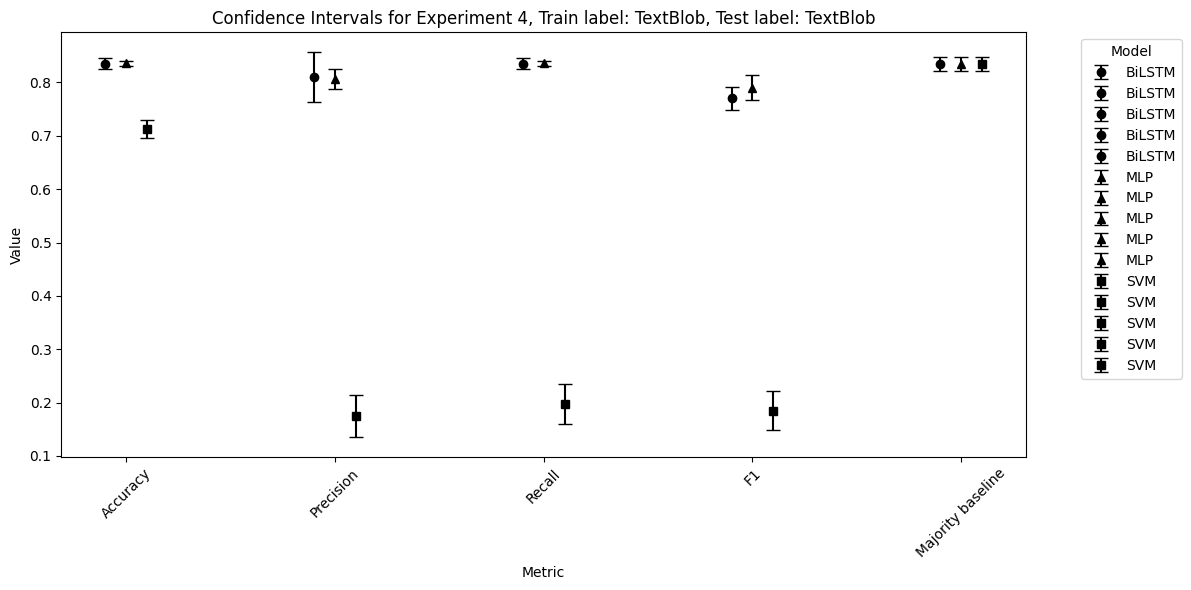

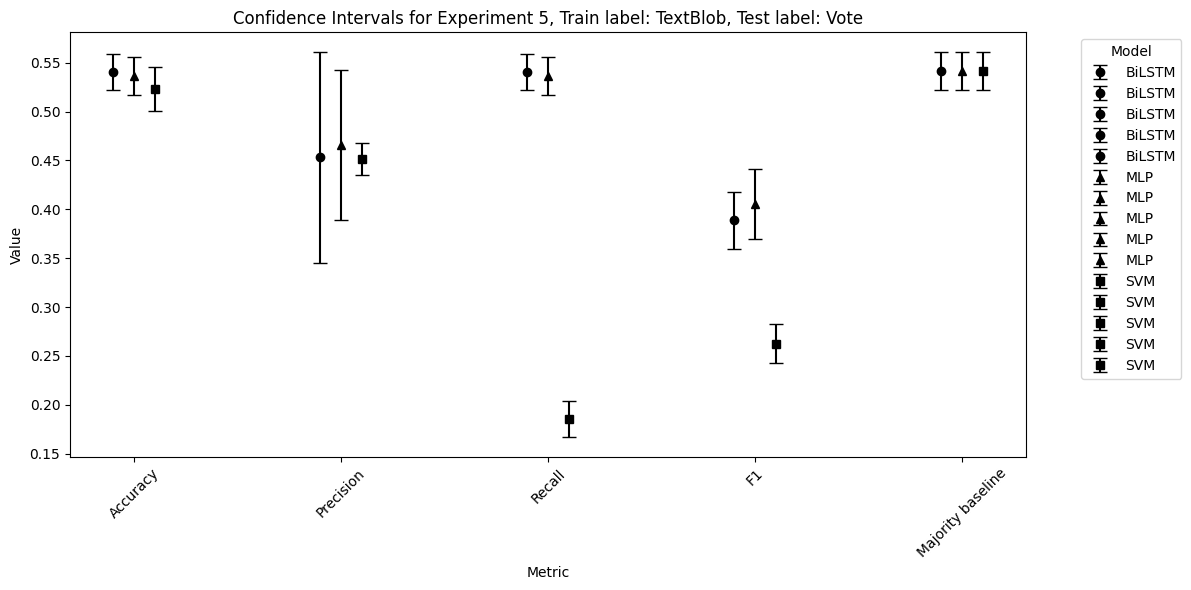

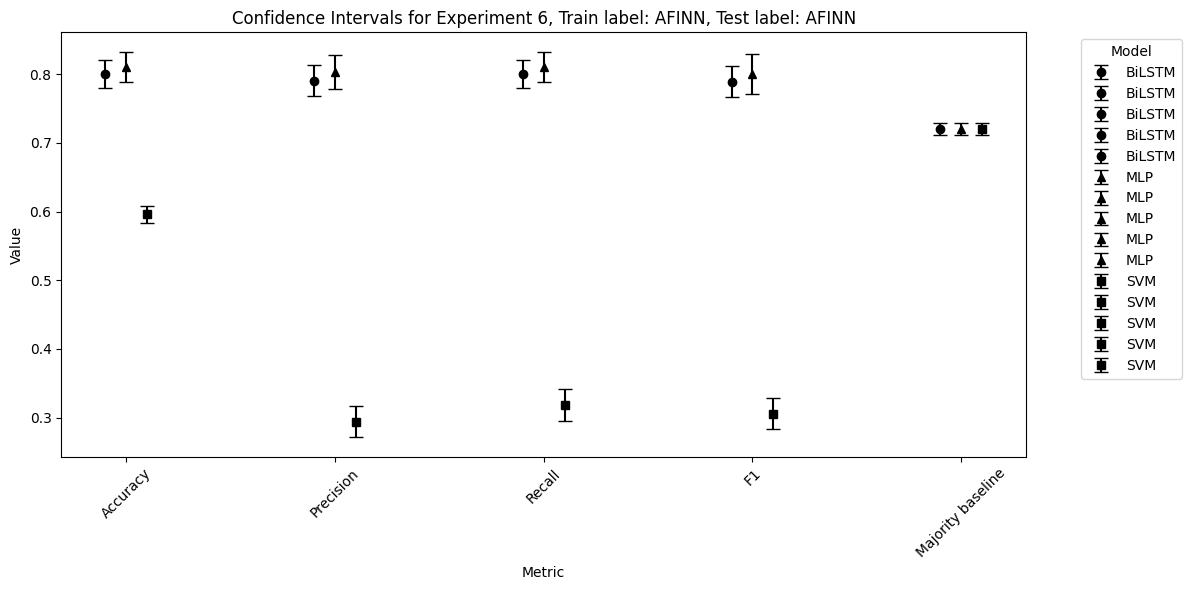

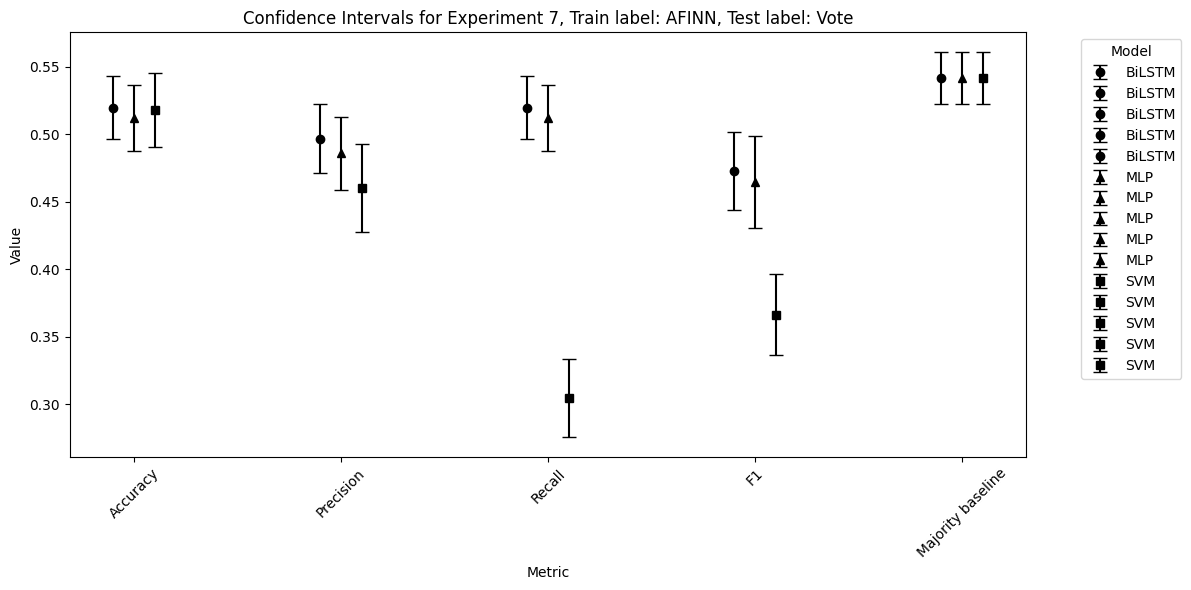

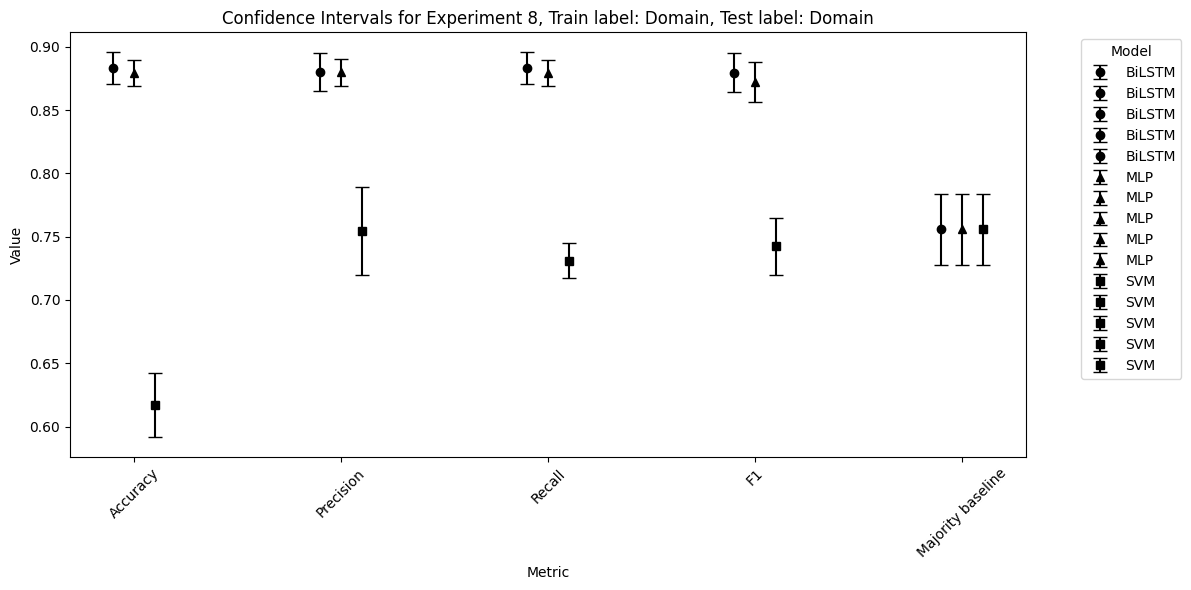

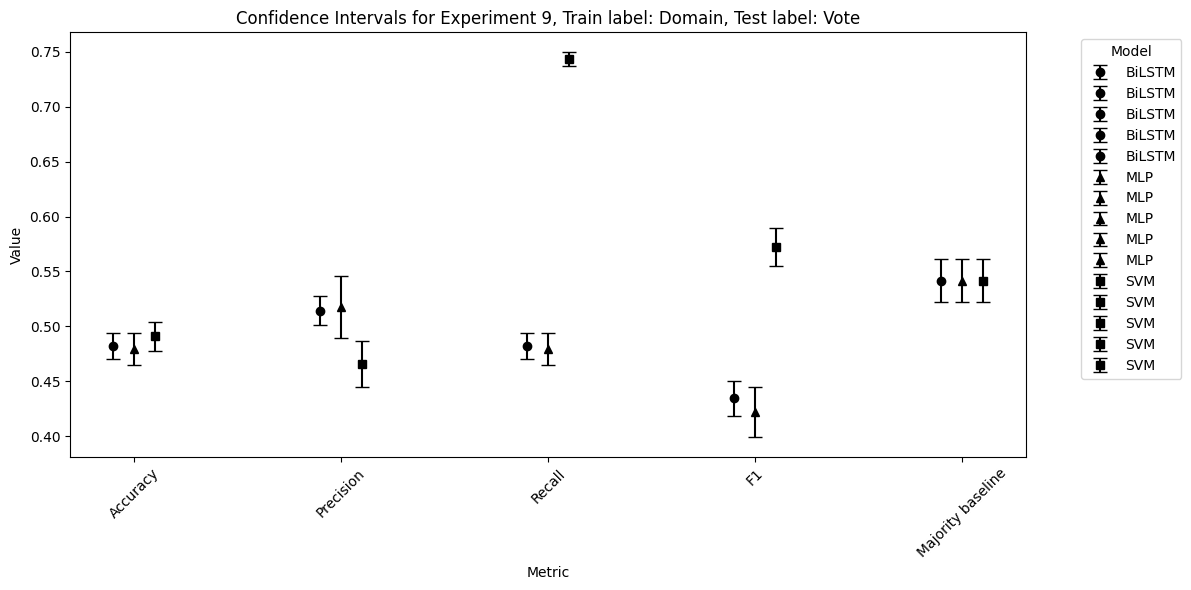

In [761]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define metrics list
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Majority baseline']

# Define models list
models = ['BiLSTM', 'MLP', 'SVM']

# Define markers for each model
markers = ['o', '^', 's']

# Slight adjustment for each model to avoid overlapping
model_position_adjustments = [-0.1, 0, 0.1]

# Loop over the experiments
for experiment in df['Experiment'].unique():
    
    # Get train and test labels for the title
    train_label = df[df['Experiment'] == experiment]['Train label'].values[0]
    test_label = df[df['Experiment'] == experiment]['Test label'].values[0]

    plt.figure(figsize=(12, 6))
    plt.title(f'Confidence Intervals for Experiment {experiment}, Train label: {train_label}, Test label: {test_label}')
    
    # Loop over the models
    for model, marker, adjustment in zip(models, markers, model_position_adjustments):
        temp_df_model = df[(df['Model'] == model) & (df['Experiment'] == experiment)]
        
        # Loop over the metrics
        for i, metric in enumerate(metrics):
            temp_df_metric = temp_df_model[[f'{metric}_mean', f'{metric}_lower', f'{metric}_upper']].values[0]
            plt.errorbar(i+adjustment, temp_df_metric[0], yerr=[[temp_df_metric[0] - temp_df_metric[1]], [temp_df_metric[2] - temp_df_metric[0]]], 
                         fmt=marker, label=model, capsize=5, color='black')
    
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.xticks(np.arange(len(metrics)), metrics, rotation=45)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()